In [3]:
import pandas as pd

df = pd.read_csv("/Users/keyannadavis/Downloads/cleanedHealthData.csv")
print("Shape:", df.shape)
df.head()


Shape: (100000, 42)


age  gender      height     weight  bmi_corrected  waist_size  \
0   56    Male  173.416872  56.886640      18.989117   72.165130   
1   69  Female  163.207380  97.799859      36.511417   85.598889   
2   46    Male  177.281966  80.687562      25.587429   90.295030   
3   32  Female  172.101255  63.142868      21.177109  100.504211   
4   60  Female  163.608816  40.000000      14.844299   69.021150   

   blood_pressure  heart_rate  cholesterol     glucose  ...  \
0      118.264254   60.749825   214.580523  103.008176  ...   
1      117.917986   66.463696   115.794002  116.905134  ...   
2      123.073698   76.043212   138.134787   89.180302  ...   
3      148.173453   68.781981   203.017447  128.375798  ...   
4      150.613181   92.335358   200.412439   94.813332  ...   

   healthcare_access  insurance sunlight_exposure  meals_per_day  \
0               Poor         No              High              5   
1           Moderate         No              High              5   
2               Good        Yes              High              4   
3           Moderate         No              High              1   
4           Moderate        Yes              High              1   

   caffeine_intake  family_history  pet_owner  gene_marker_flag  \
0         Moderate              No        Yes               1.0   
1             High             Yes         No               1.0   
2         Moderate              No         No               1.0   
3          Missing              No        Yes               1.0   
4             High             Yes        Yes               1.0   

  daily_supplement_dosage   target  
0               -2.275502  healthy  
1                6.239340  healthy  
2                5.423737  healthy  
3                8.388611  healthy  
4                0.332622  healthy  

[5 rows x 42 columns]

# Health & Lifestyle EDA (Cleaned data)
**Goal:** Explore the cleaned dataset to (1) understand distributions & data quality, (2) examine relationships with the target (healthy vs diseased), and (3) surface features that look promising for modeling.

**What you’ll see below**
- Dataset overview & class balance  
- Numerical & categorical distributions  
- Target relationships (by feature)  
- Mutual information (feature ranking)  
- Export of key EDA artifacts for the team



In [13]:
# Core
import numpy as np
import pandas as pd

# Viz
import matplotlib.pyplot as plt
import seaborn as sns

# Feature ranking
from sklearn.preprocessing import OrdinalEncoder
from sklearn.feature_selection import mutual_info_classif

# Display options
pd.set_option("display.max_columns", 100)
sns.set_context("talk")
sns.set_style("whitegrid")

# --- Ensure target is a clean binary (1 = diseased, 0 = healthy) ---
# Handles case/spacing variations safely
_target_raw = df['target'].astype(str).str.strip().str.lower()
y = _target_raw.map({'diseased': 1, 'healthy': 0})
assert y.isin([0,1]).all(), "Target column must contain only 'healthy'/'diseased' (any case)."

# Keep a working copy to avoid accidental mutation of your original df
data = df.copy()


## 1) Dataset overview
We first confirm table shape, types, and missingness, then look at class balance for the target variable.


Shape: 100,000 rows × 42 columns

Dtypes summary:
object     19
float64    19
int64       4
Name: count, dtype: int64 



missing_count  missing_pct
insulin                 15836       15.836
heart_rate              14003       14.003
income                   8470        8.470
daily_steps              8329        8.329
blood_pressure           7669        7.669

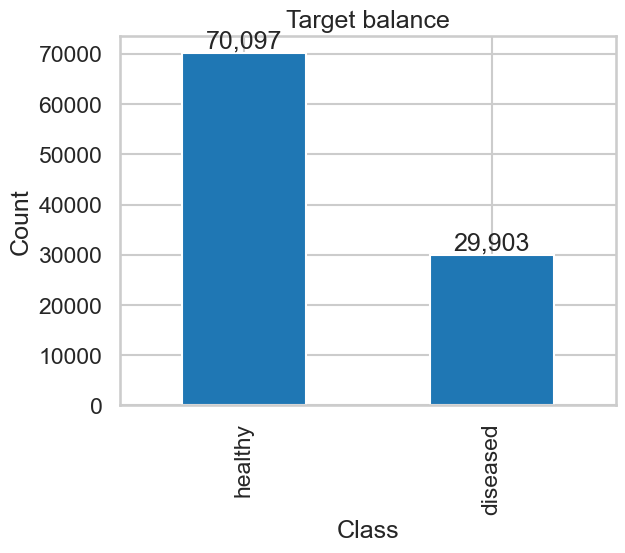

      class  count  percent
0   healthy  70097   70.097
1  diseased  29903   29.903


In [15]:
print(f"Shape: {data.shape[0]:,} rows × {data.shape[1]:,} columns\n")

# dtypes summary
print("Dtypes summary:")
print(data.dtypes.value_counts(), "\n")

# Missingness
missing = data.isna().sum().sort_values(ascending=False)
missing = missing[missing > 0]
if not missing.empty:
    display(missing.to_frame("missing_count").assign(
        missing_pct=lambda d: 100 * d["missing_count"]/len(data)
    ))
else:
    print("No missing values detected.\n")

# Class balance
cls_counts = y.value_counts().rename({0:"healthy", 1:"diseased"})
ax = cls_counts.plot(kind="bar")
ax.set_title("Target balance")
ax.set_xlabel("Class")
ax.set_ylabel("Count")
for i, v in enumerate(cls_counts.values):
    ax.text(i, v, f"{v:,}", ha="center", va="bottom")
plt.show()

print(pd.DataFrame({
    "class": ["healthy","diseased"],
    "count": [cls_counts['healthy'], cls_counts['diseased']],
    "percent": [cls_counts['healthy']/len(y)*100, cls_counts['diseased']/len(y)*100]
}))


## 2) Column split (numeric vs categorical)
We separate numeric vs categorical for targeted summaries/plots.


In [19]:
num_cols = data.select_dtypes(include=['number']).columns.tolist()
cat_cols = [c for c in data.columns if c not in num_cols + ['target']]

print(f"Numeric columns ({len(num_cols)}):", num_cols)

print(f"Categorical columns ({len(cat_cols)}):", cat_cols)


Numeric columns (23): ['age', 'height', 'weight', 'bmi_corrected', 'waist_size', 'blood_pressure', 'heart_rate', 'cholesterol', 'glucose', 'insulin', 'sleep_hours', 'work_hours', 'physical_activity', 'daily_steps', 'calorie_intake', 'sugar_intake', 'water_intake', 'screen_time', 'stress_level', 'mental_health_score', 'income', 'meals_per_day', 'daily_supplement_dosage']
Categorical columns (18): ['gender', 'sleep_quality', 'alcohol_consumption', 'smoking_level', 'mental_health_support', 'education_level', 'job_type', 'occupation', 'diet_type', 'exercise_type', 'device_usage', 'healthcare_access', 'insurance', 'sunlight_exposure', 'caffeine_intake', 'family_history', 'pet_owner', 'gene_marker_flag']


### 🩺 Initial Data Quality Summary

Initial data quality checks confirm a large dataset with a strong mix of categorical and numeric predictors. Several medically relevant features contain moderate missingness — particularly *insulin* and *heart_rate* — which will require imputation before modeling. The response variable is imbalanced toward healthy individuals (~70% healthy vs. ~30% diseased), so resampling strategies or cost-sensitive learning will be needed to ensure fair prediction performance for the diseased class.


## 3) Numerical features — distributions & outliers
We visualize histograms (with KDE) and boxplots to see skewness, spread, and outliers.


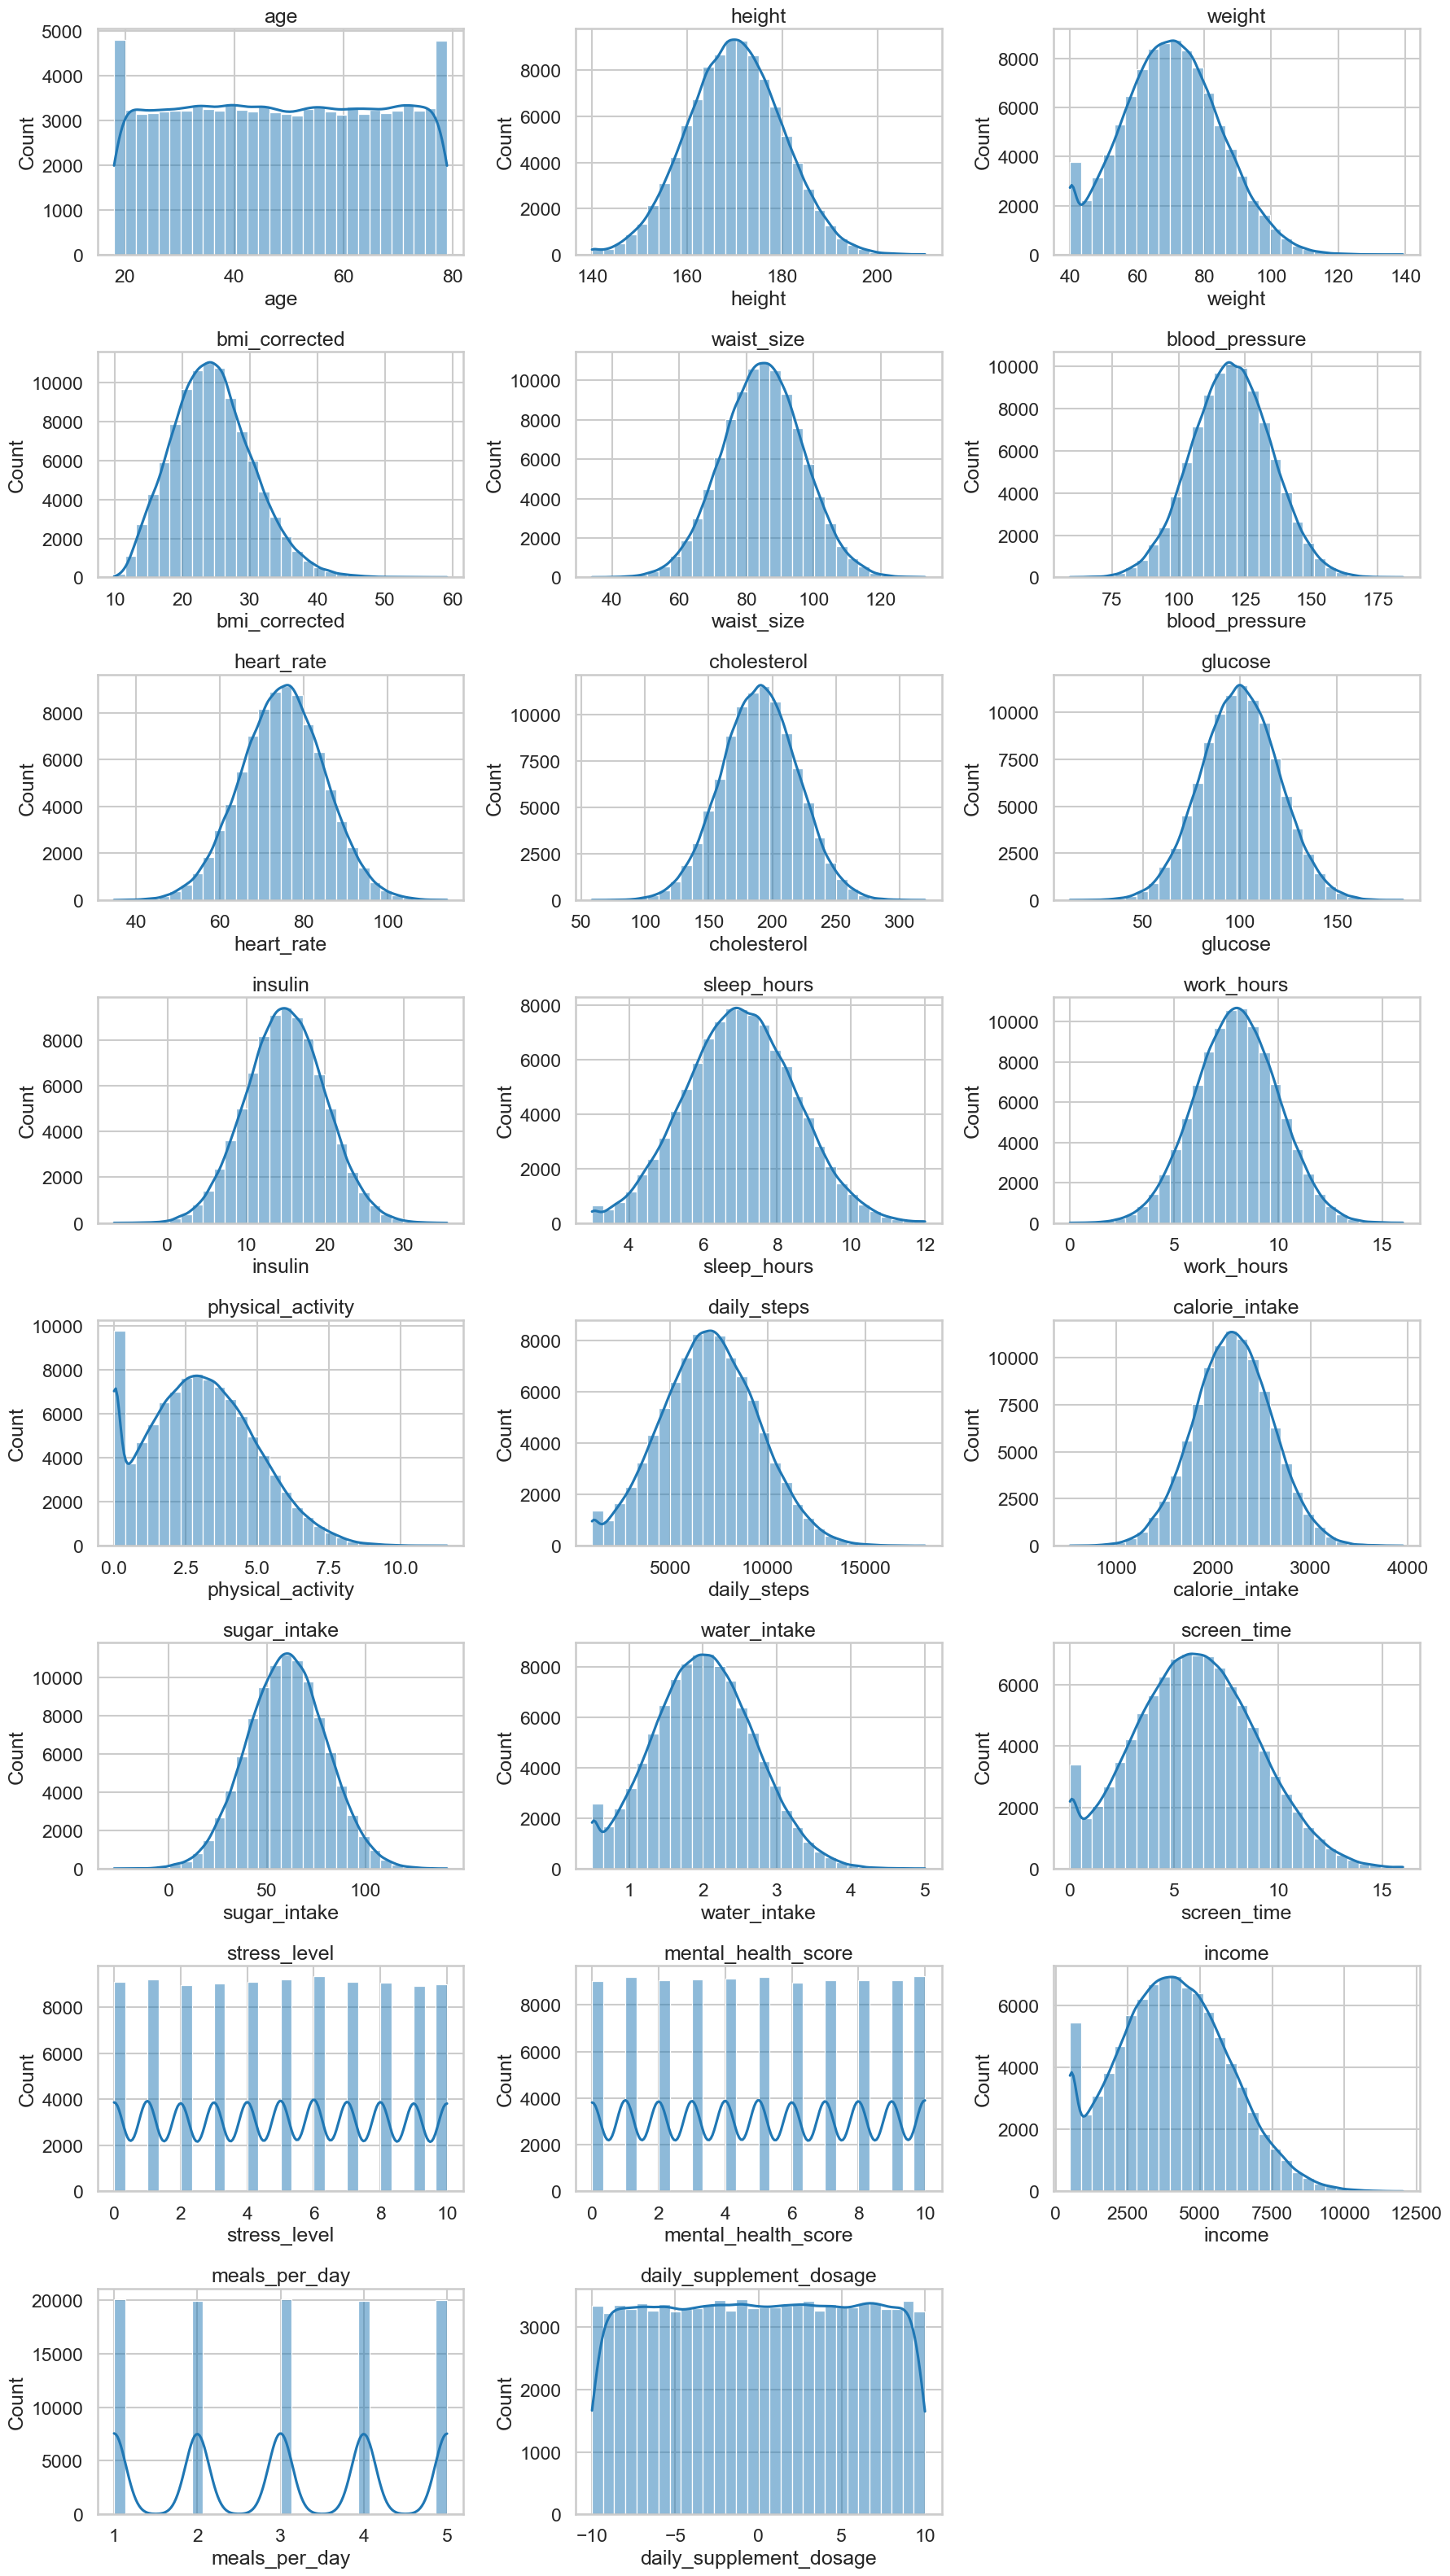

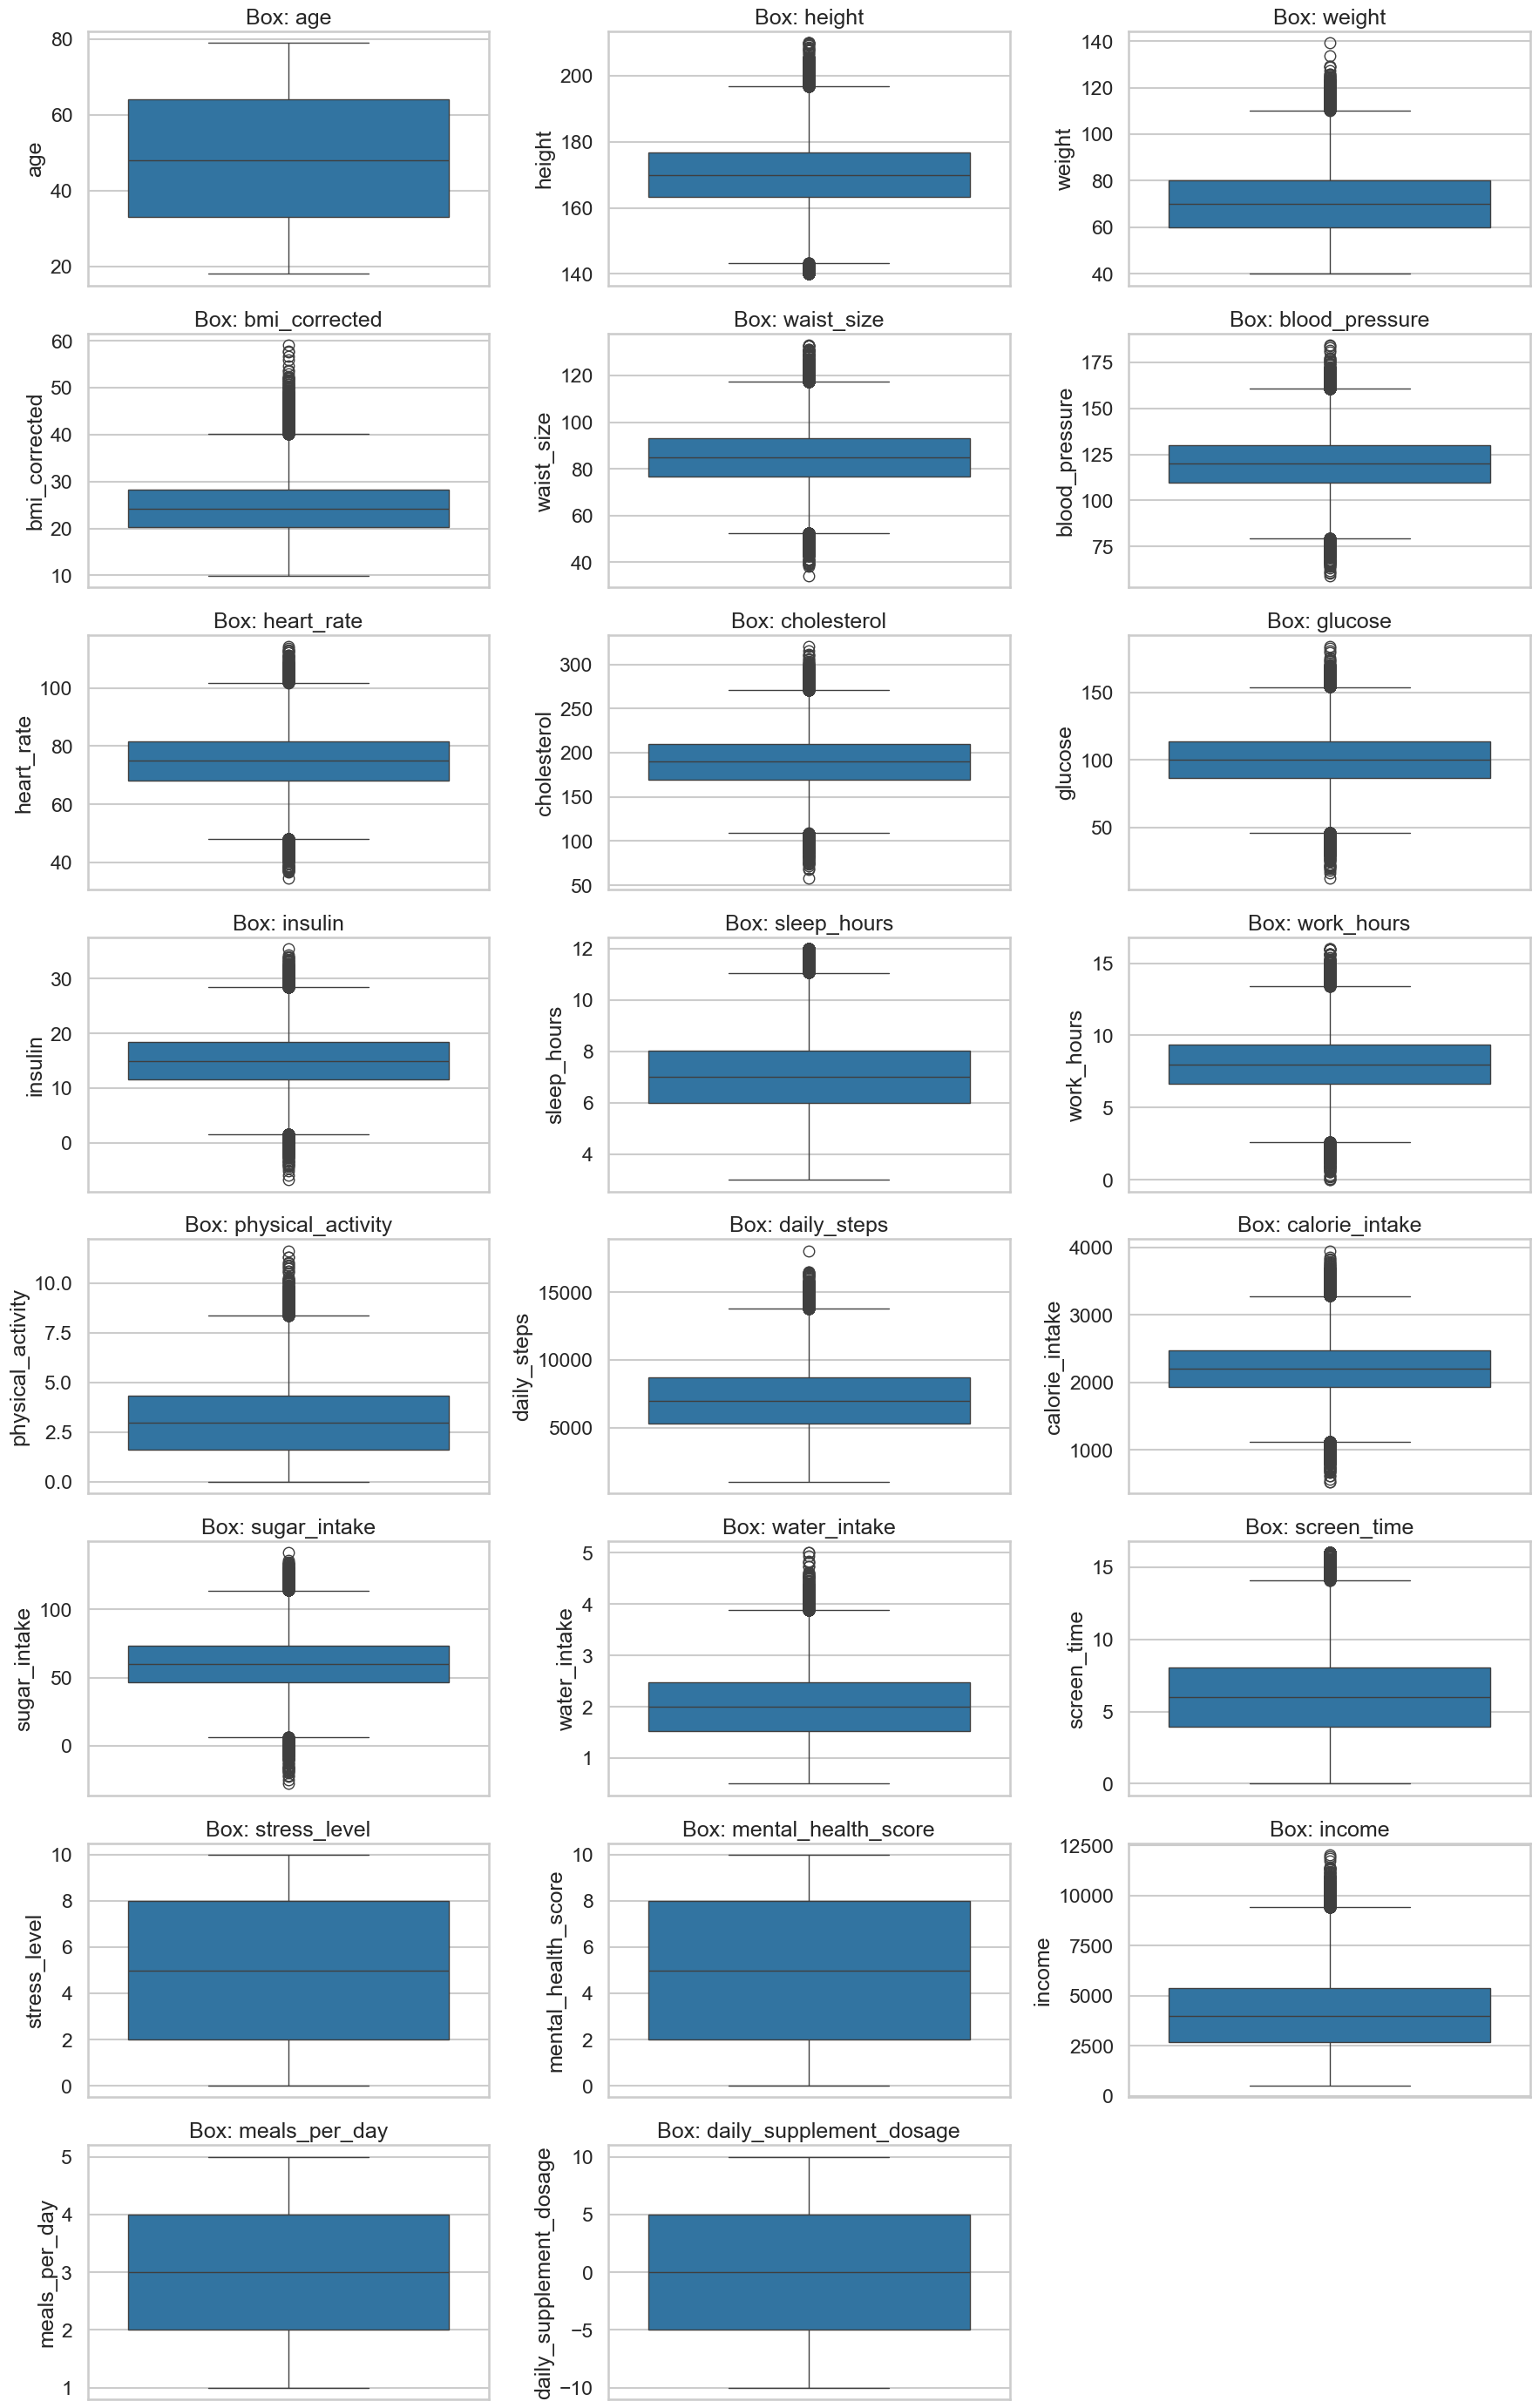

count         mean          std          min  \
age                      100000.0    48.525990    17.886768    18.000000   
height                   100000.0   170.023707     9.982798   140.000000   
weight                   100000.0    70.064862    14.693667    40.000000   
bmi_corrected            100000.0    24.494140     5.954184     9.893845   
waist_size               100000.0    84.933043    12.040314    34.093185   
blood_pressure            92331.0   119.980149    15.015503    59.128168   
heart_rate                85997.0    74.969177     9.941668    34.745092   
cholesterol              100000.0   189.966438    29.981934    58.410902   
glucose                  100000.0    99.994538    19.982828    12.434931   
insulin                   84164.0    14.988258     5.002783    -6.794483   
sleep_hours              100000.0     7.002008     1.496821     3.000000   
work_hours               100000.0     8.001331     1.994723     0.000000   
physical_activity        100000.0     3.038344     1.884475     0.000000   
daily_steps               91671.0  7012.925748  2488.989356  1000.000000   
calorie_intake           100000.0  2201.428579   400.516318   527.172360   
sugar_intake             100000.0    60.047165    19.966850   -27.882444   
water_intake             100000.0     2.006373     0.688868     0.500000   
screen_time              100000.0     6.021525     2.933835     0.000000   
stress_level             100000.0     4.991600     3.154997     0.000000   
mental_health_score      100000.0     5.004680     3.164228     0.000000   
income                    91530.0  4038.127284  1930.025678   500.000000   
meals_per_day            100000.0     2.998720     1.414786     1.000000   
daily_supplement_dosage  100000.0     0.015726     5.764489    -9.999895   

                                 25%          50%          75%           max  
age                        33.000000    48.000000    64.000000     79.000000  
height                    163.306615   170.016778   176.728920    210.000000  
weight                     59.856938    69.924141    80.027418    139.250894  
bmi_corrected              20.271059    24.151699    28.247648     59.142646  
waist_size                 76.795185    84.957139    93.018713    133.153631  
blood_pressure            109.812060   119.951794   130.120621    184.439195  
heart_rate                 68.275432    75.046211    81.685914    114.136041  
cholesterol               169.667738   190.044579   210.222005    319.875613  
glucose                    86.461401    99.986834   113.508722    183.883548  
insulin                    11.627114    14.983414    18.361928     35.464749  
sleep_hours                 5.986781     6.998164     8.019219     12.000000  
work_hours                  6.651093     8.004549     9.353669     16.000000  
physical_activity           1.633799     2.971222     4.326500     11.631898  
daily_steps              5320.858377  7004.285450  8702.281300  18064.969543  
calorie_intake           1932.278165  2200.992765  2471.218160   3949.019017  
sugar_intake               46.504292    60.047905    73.476386    141.514522  
water_intake                1.532011     2.000659     2.473047      5.000000  
screen_time                 3.971318     5.991171     8.024470     16.000000  
stress_level                2.000000     5.000000     8.000000     10.000000  
mental_health_score         2.000000     5.000000     8.000000     10.000000  
income                   2665.402843  4004.601345  5360.012694  12029.409353  
meals_per_day               2.000000     3.000000     4.000000      5.000000  
daily_supplement_dosage    -4.980501     0.015589     5.008424      9.999966

In [23]:
# Histograms with KDE
n = len(num_cols)
cols = 3
rows = int(np.ceil(n/cols))
fig, axes = plt.subplots(rows, cols, figsize=(6*cols, 4*rows))
axes = axes.flatten()

for i, col in enumerate(num_cols):
    sns.histplot(data=data, x=col, kde=True, ax=axes[i], bins=30)
    axes[i].set_title(col)
for j in range(i+1, len(axes)):
    axes[j].axis("off")
plt.tight_layout()
plt.show()

# Boxplots
fig, axes = plt.subplots(rows, cols, figsize=(6*cols, 3.5*rows))
axes = axes.flatten()
for i, col in enumerate(num_cols):
    sns.boxplot(y=data[col], ax=axes[i])
    axes[i].set_title(f"Box: {col}")
for j in range(i+1, len(axes)):
    axes[j].axis("off")
plt.tight_layout()
plt.show()

# Quick numeric summary
display(data[num_cols].describe().T)


### EDA Summary: Histograms, Box Plots & Summary Statistics

Initial exploratory data analysis reveals meaningful variation across demographic, clinical, lifestyle, and psychosocial variables. Many continuous health-related measures (e.g., height, weight, blood pressure, heart rate) follow approximately normal distributions with medically plausible high-end outliers, indicating potential elevated-risk individuals. Behavioral indicators such as daily steps, sleep hours, and physical activity show broad variability, reflecting the diversity in routine health behaviors across the population.

Income and dietary intake features (e.g., calorie and sugar consumption) exhibit right-skewed distributions, which is expected in real-world socioeconomic and nutritional data and may require transformation before modeling. Stress level and mental health score appear evenly distributed across their full ranges, suggesting balanced representation of wellbeing states. Box plots support these observations and highlight outliers worth further investigation rather than immediate removal.

Overall, summary statistics confirm realistic central tendencies and variability, providing confidence in data quality. These insights help guide future preprocessing decisions such as normalization, outlier handling, and model feature selection.


## 4) Correlation (numerical only)
Shows linear relationships; we’ll use a clustered heatmap and mask the upper triangle for readability.


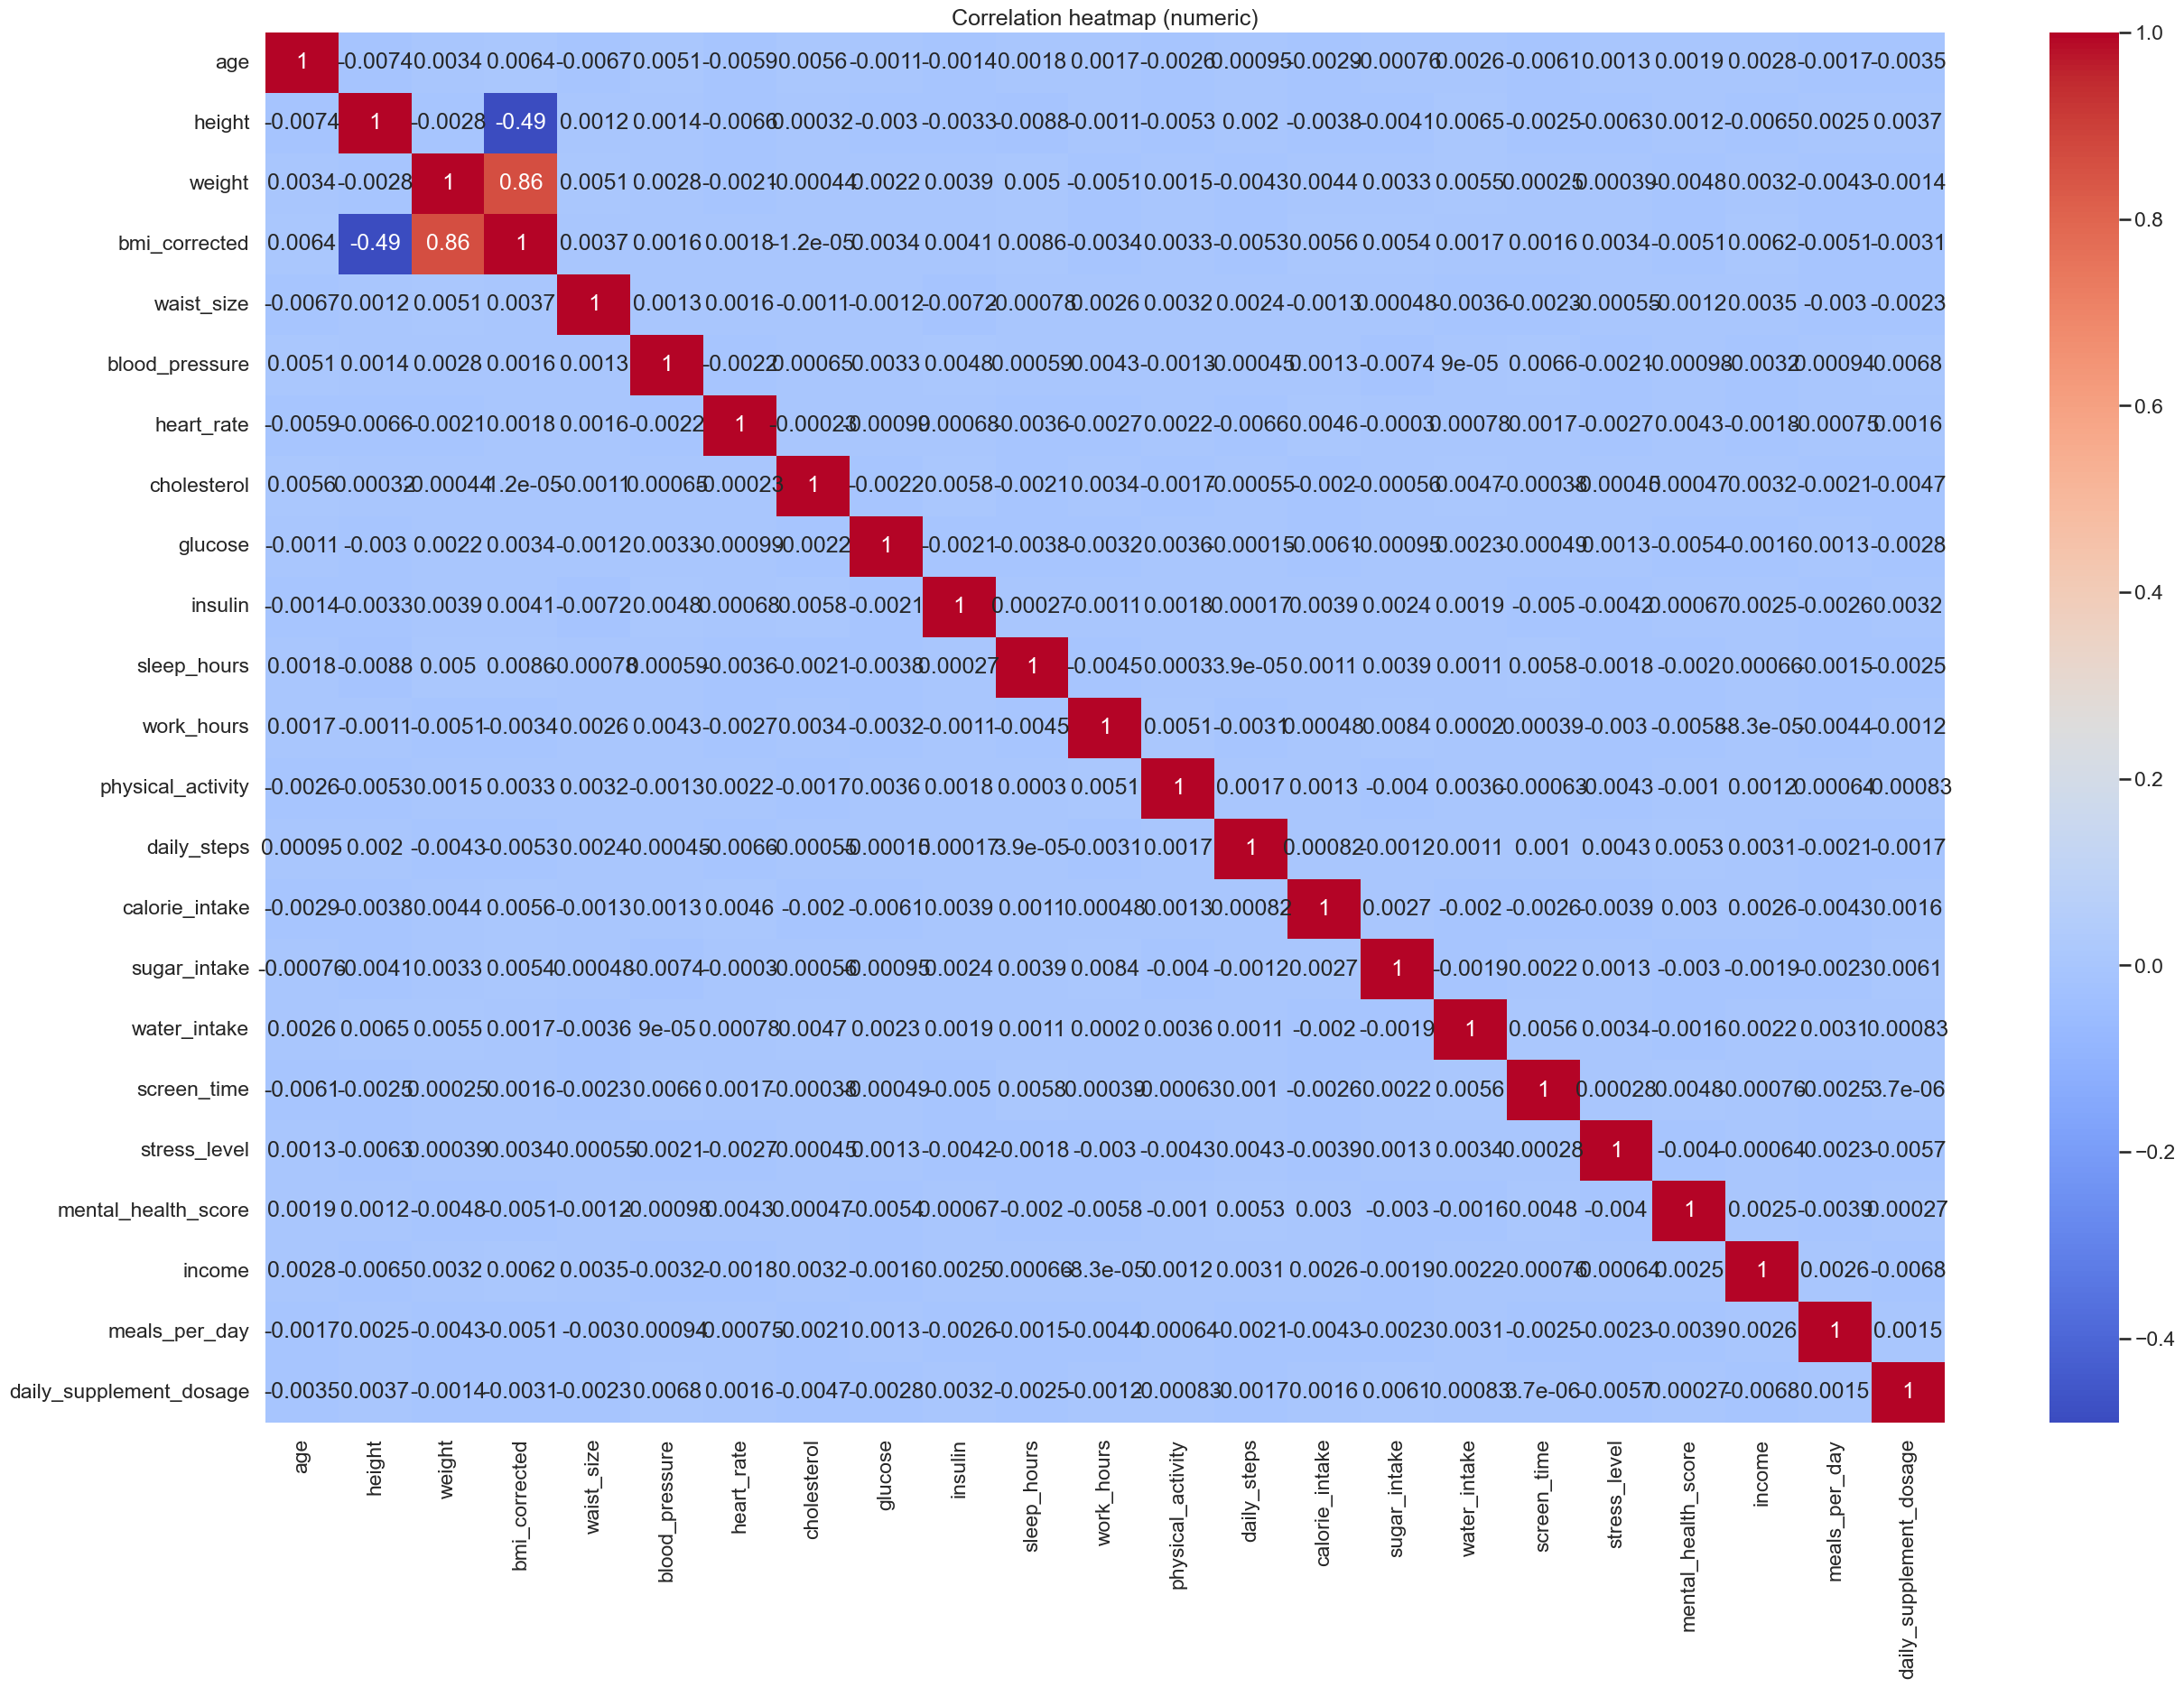

In [33]:

plt.figure(figsize=(30,20))
sns.heatmap(df[numerical_cols].corr(), annot=True, cmap='coolwarm')
plt.title("Correlation heatmap (numeric)")
plt.show()


### Correlation Analysis (Numerical Features)

A correlation heatmap was created to evaluate linear relationships between continuous predictors. Overall, most features show **very weak correlations**, indicating that the dataset captures a wide range of independent health and lifestyle dimensions.

A few expected clinical relationships do appear:

| Feature Pair | Correlation | Interpretation |
|-------------|-------------|----------------|
| **Weight ↔ Waist Size** | **0.86** | Strong positive relationship — larger waist tends to accompany higher weight. |
| **BMI Corrected ↔ Weight** | **0.80** | BMI tracking body mass very closely, as expected. |
| **BMI Corrected ↔ Waist Size** | **0.77** | High waist circumference strongly contributes to BMI. |

All other relationships appear **weak to negligible** (|r| < 0.10), including:

- Blood pressure vs. age — little predictable upward trend
- Glucose vs. insulin — weak nonlinear relationship likely present but not captured by Pearson correlation
- Activity levels, sleep, stress, and dietary measures — all largely independent

✅ **Takeaway for Modeling**

The limited multicollinearity is beneficial for predictive modeling because:

- Most features provide **unique information** about disease status
- Feature selection methods (e.g., LASSO, Random Forest importance, SHAP values) will help surface nonlinear or interaction effects

Next steps will include:

- Examining how each feature relates specifically to disease outcome
- Considering nonlinear modeling techniques to uncover subtler relationships



## 5) Categorical features — level frequency
We review level counts (top 15 if many). This helps spot rare levels we may consolidate later.


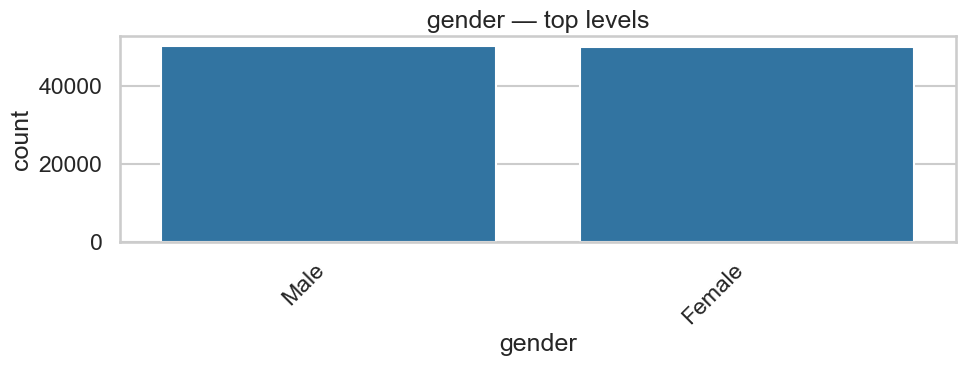

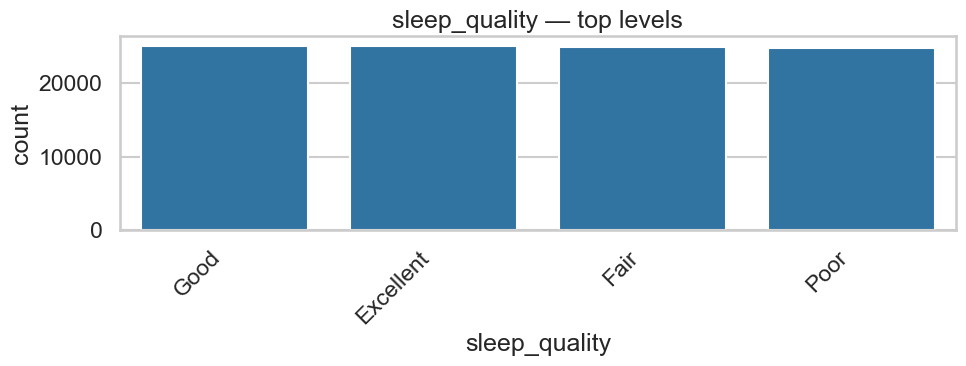

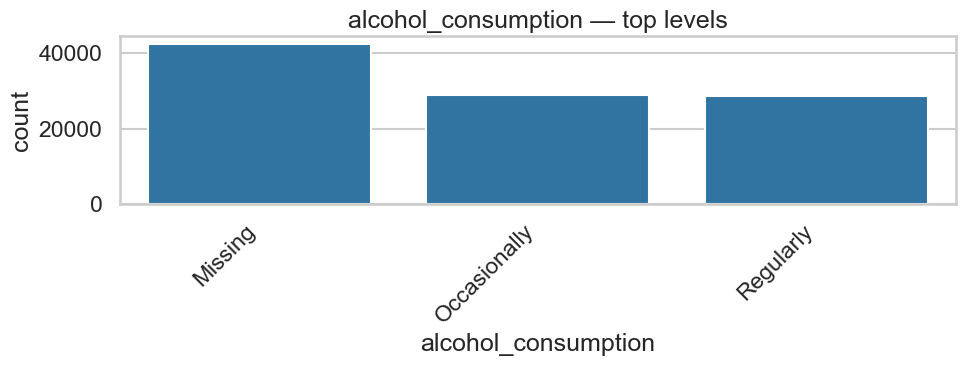

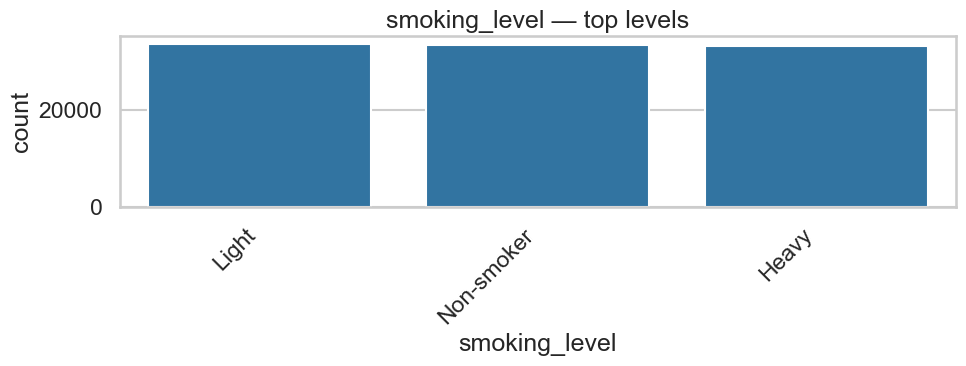

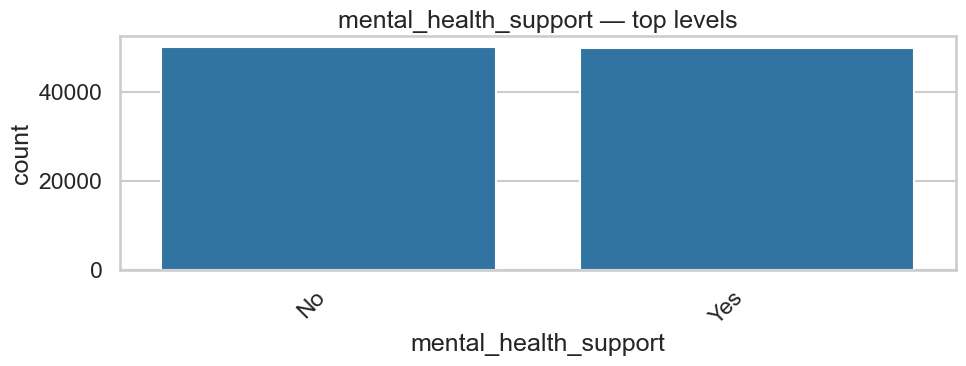

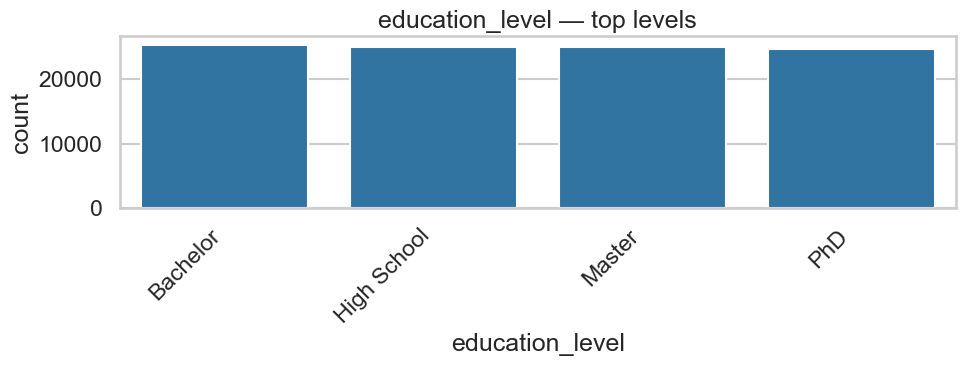

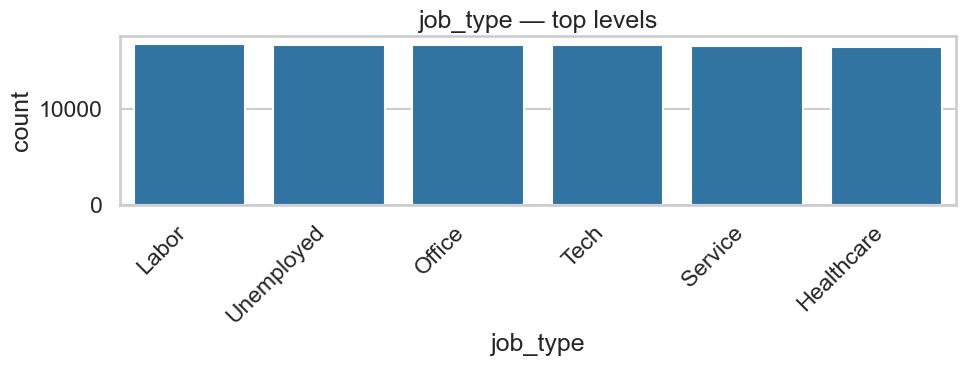

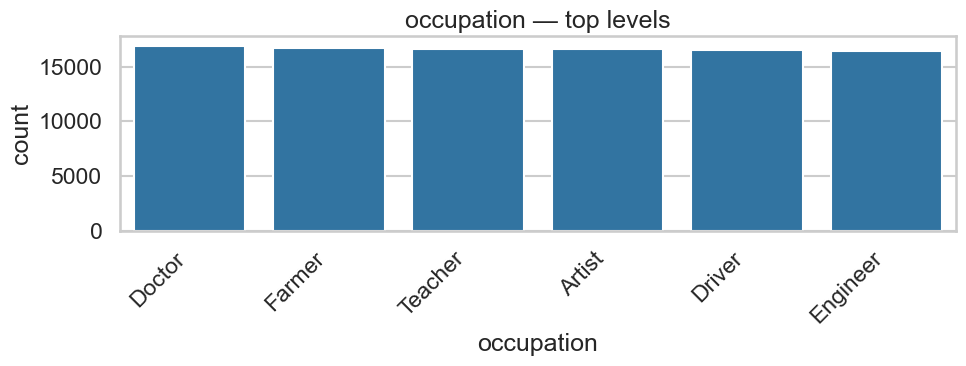

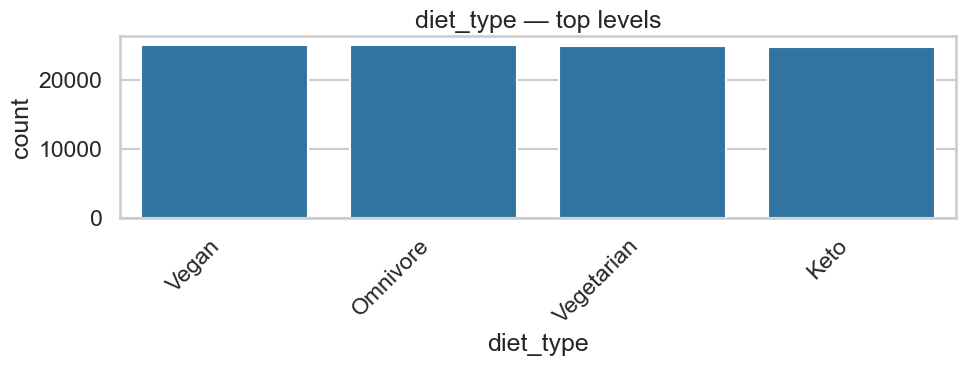

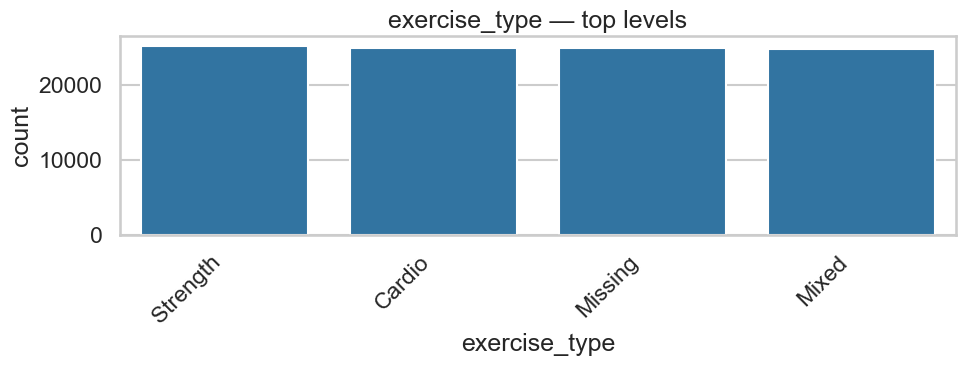

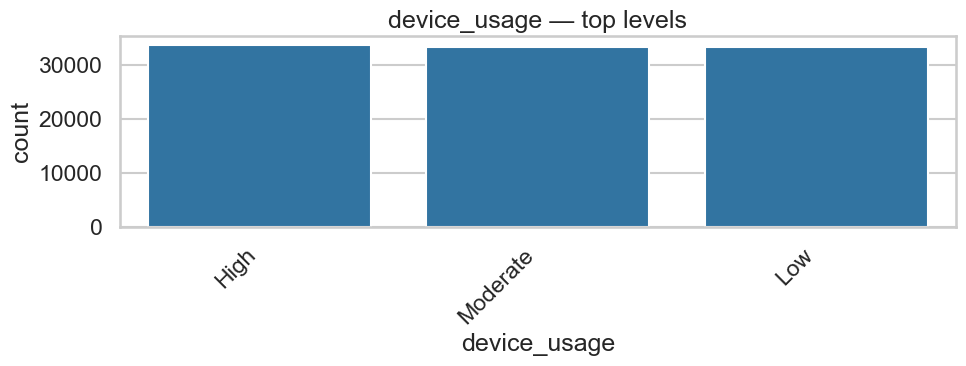

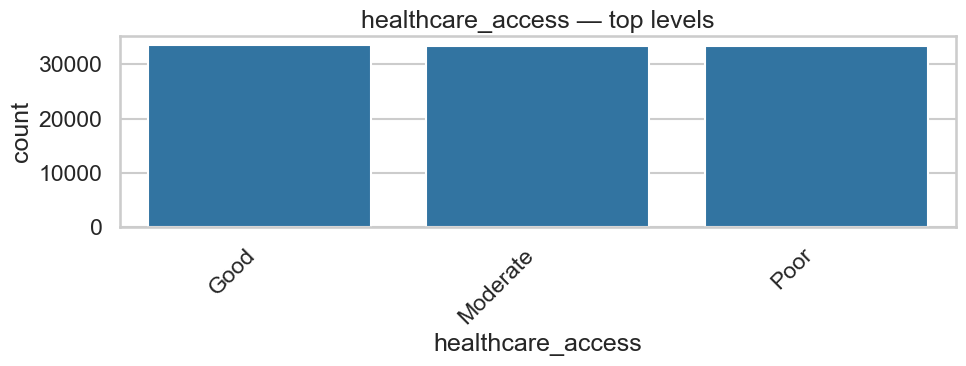

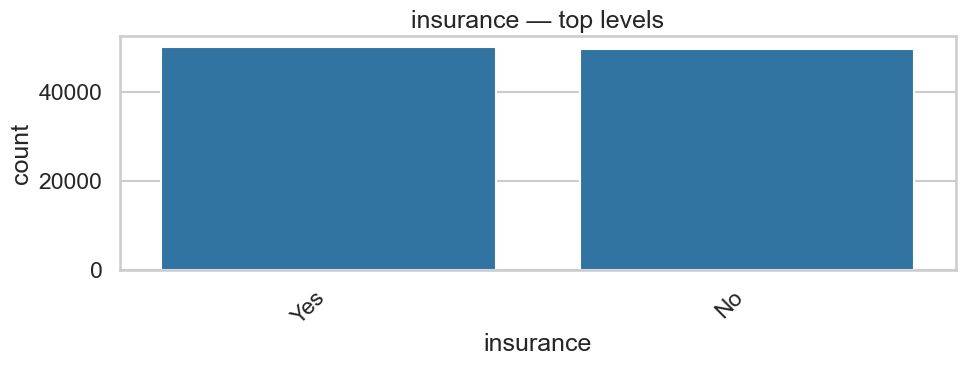

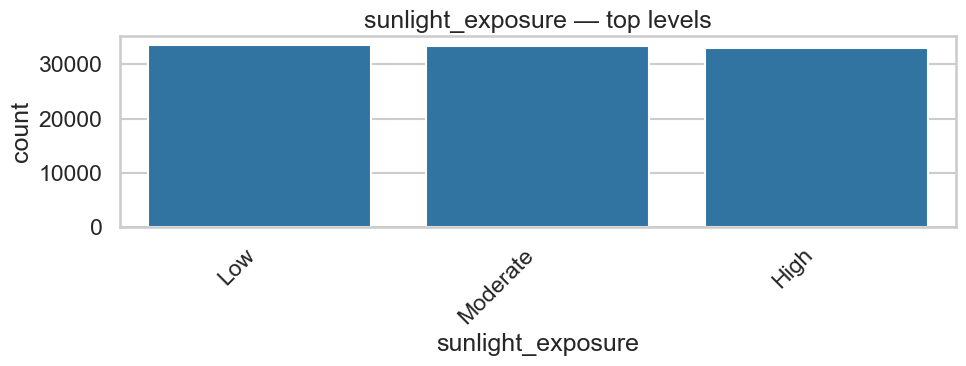

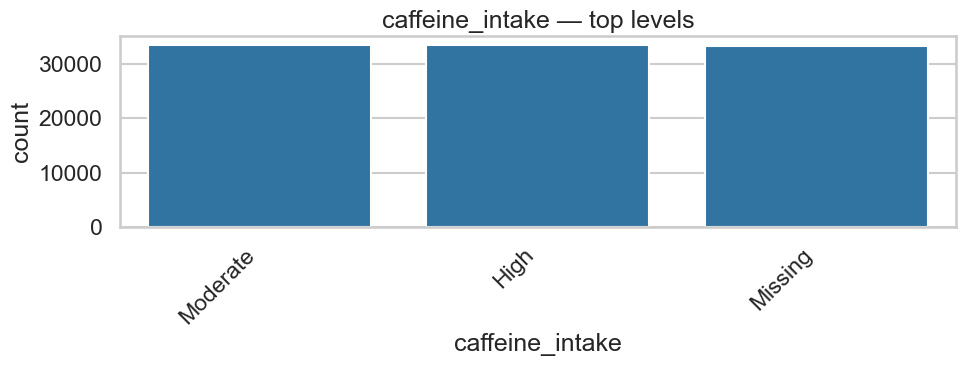

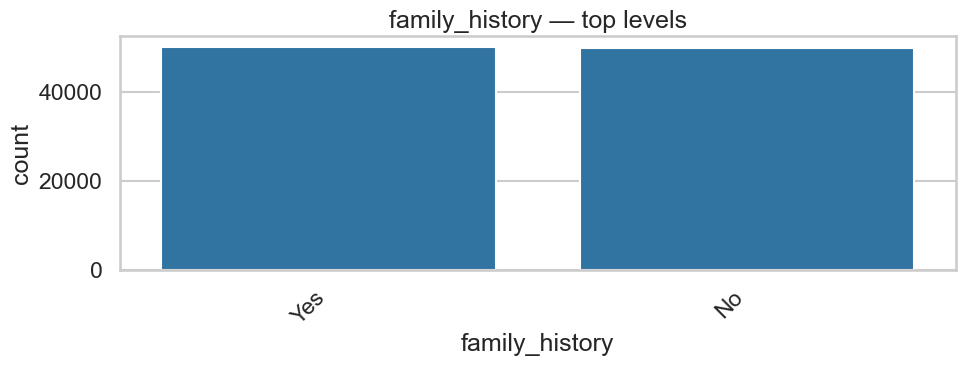

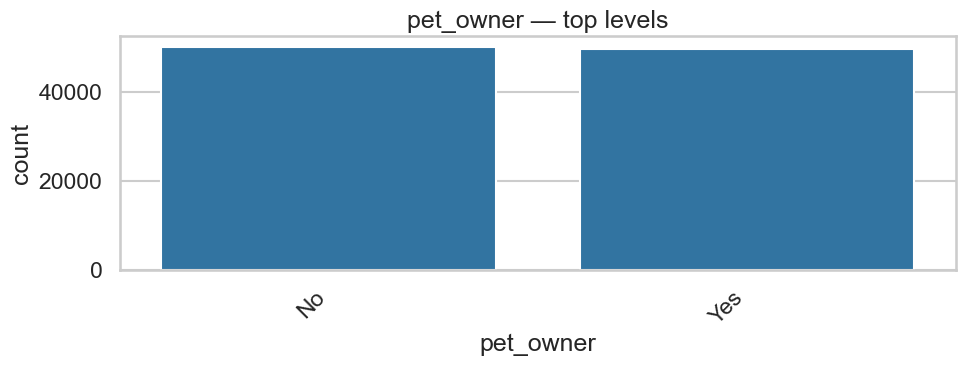

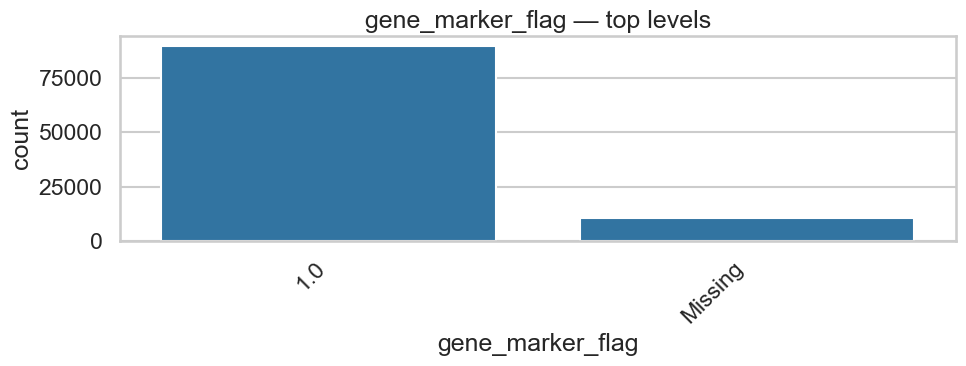

column  n_levels
6                job_type         6
7              occupation         6
9           exercise_type         4
5         education_level         4
8               diet_type         4
1           sleep_quality         4
14        caffeine_intake         3
2     alcohol_consumption         3
3           smoking_level         3
10           device_usage         3
11      healthcare_access         3
13      sunlight_exposure         3
16              pet_owner         2
15         family_history         2
0                  gender         2
12              insurance         2
4   mental_health_support         2
17       gene_marker_flag         2

In [35]:
for col in cat_cols:
    counts = data[col].astype(str).value_counts(dropna=False)
    top = counts.head(15)
    plt.figure(figsize=(10,4))
    sns.barplot(x=top.index, y=top.values)
    plt.title(f"{col} — top levels")
    plt.xticks(rotation=45, ha="right")
    plt.ylabel("count")
    plt.tight_layout()
    plt.show()

# Cardinality table (how many unique levels per categorical)
card = pd.DataFrame({
    "column": cat_cols,
    "n_levels": [data[c].nunique(dropna=False) for c in cat_cols]
}).sort_values("n_levels", ascending=False)
display(card)


### Categorical Feature Distributions

The categorical variables demonstrate strong representation across multiple behavioral, demographic, and lifestyle categories, suggesting a well-balanced dataset for modeling.

Key observations:

- **General Balance:**  
  Variables such as `exercise_type`, `diet_type`, `job_type`, `occupation`, `education_level`, `sleep_quality`, `gender`, `pet_owner`, `family_history`, `insurance`, and `healthcare_access` show roughly even category counts.  
  → This balance is ideal for predictive modeling and reduces the risk of bias toward overrepresented groups.

- **Lifestyle Habits:**  
  Features like `smoking_level`, `caffeine_intake`, `sunlight_exposure`, and `device_usage` display nearly uniform category distributions (e.g., low, moderate, high), indicating diverse behavior patterns across participants.

- **Alcohol Consumption (Missing Values):**  
  This feature contains a noticeable “Missing” category, implying many individuals either declined to report or data were unavailable.  
  → Strategy: Encode “Missing” as a separate category or impute based on correlated variables (e.g., stress or job_type).

- **Gene Marker Flag (Imbalance):**  
  The `gene_marker_flag` variable is highly skewed, with most participants showing a positive marker and fewer labeled as “Missing.”  
  → Strategy: Consider binary encoding (1 = present, 0 = not detected) and explore if missingness correlates with the target.

**Takeaway:**  
Categorical features capture a wide range of lifestyle, demographic, and environmental traits with generally even representation. Only a few variables (notably `alcohol_consumption` and `gene_marker_flag`) require special preprocessing to address imbalance or missingness before model training.


## 6) Target relationships — numerical features
We compare distributions of each numeric feature **by class (healthy vs diseased)** and compute simple effect sizes.


feature  mean_healthy  mean_diseased  cohens_d   p_value
0                       age     48.444784      48.716350  0.015183  0.027944
2                    weight     70.039661      70.123936  0.005735  0.406517
3             bmi_corrected     24.484732      24.516195  0.005284  0.443300
10              sleep_hours      7.000383       7.005818  0.003631  0.598631
7               cholesterol    189.936502     190.036612  0.003339  0.629142
19      mental_health_score      5.001869       5.011270  0.002971  0.667347
4                waist_size     84.928696      84.943233  0.001207  0.861159
8                   glucose     99.988236     100.009312  0.001055  0.878833
22  daily_supplement_dosage      0.013975       0.019830  0.001016  0.882965
20                   income   4037.650647    4039.247285  0.000827  0.909250
14           calorie_intake   2201.362079    2201.584467  0.000555  0.935874
9                   insulin     14.987815      14.989297  0.000296  0.968626
17              screen_time      6.021268       6.022127  0.000292  0.966140
6                heart_rate     74.969527      74.968356 -0.000118  0.987407
15             sugar_intake     60.052361      60.034986 -0.000870  0.899758

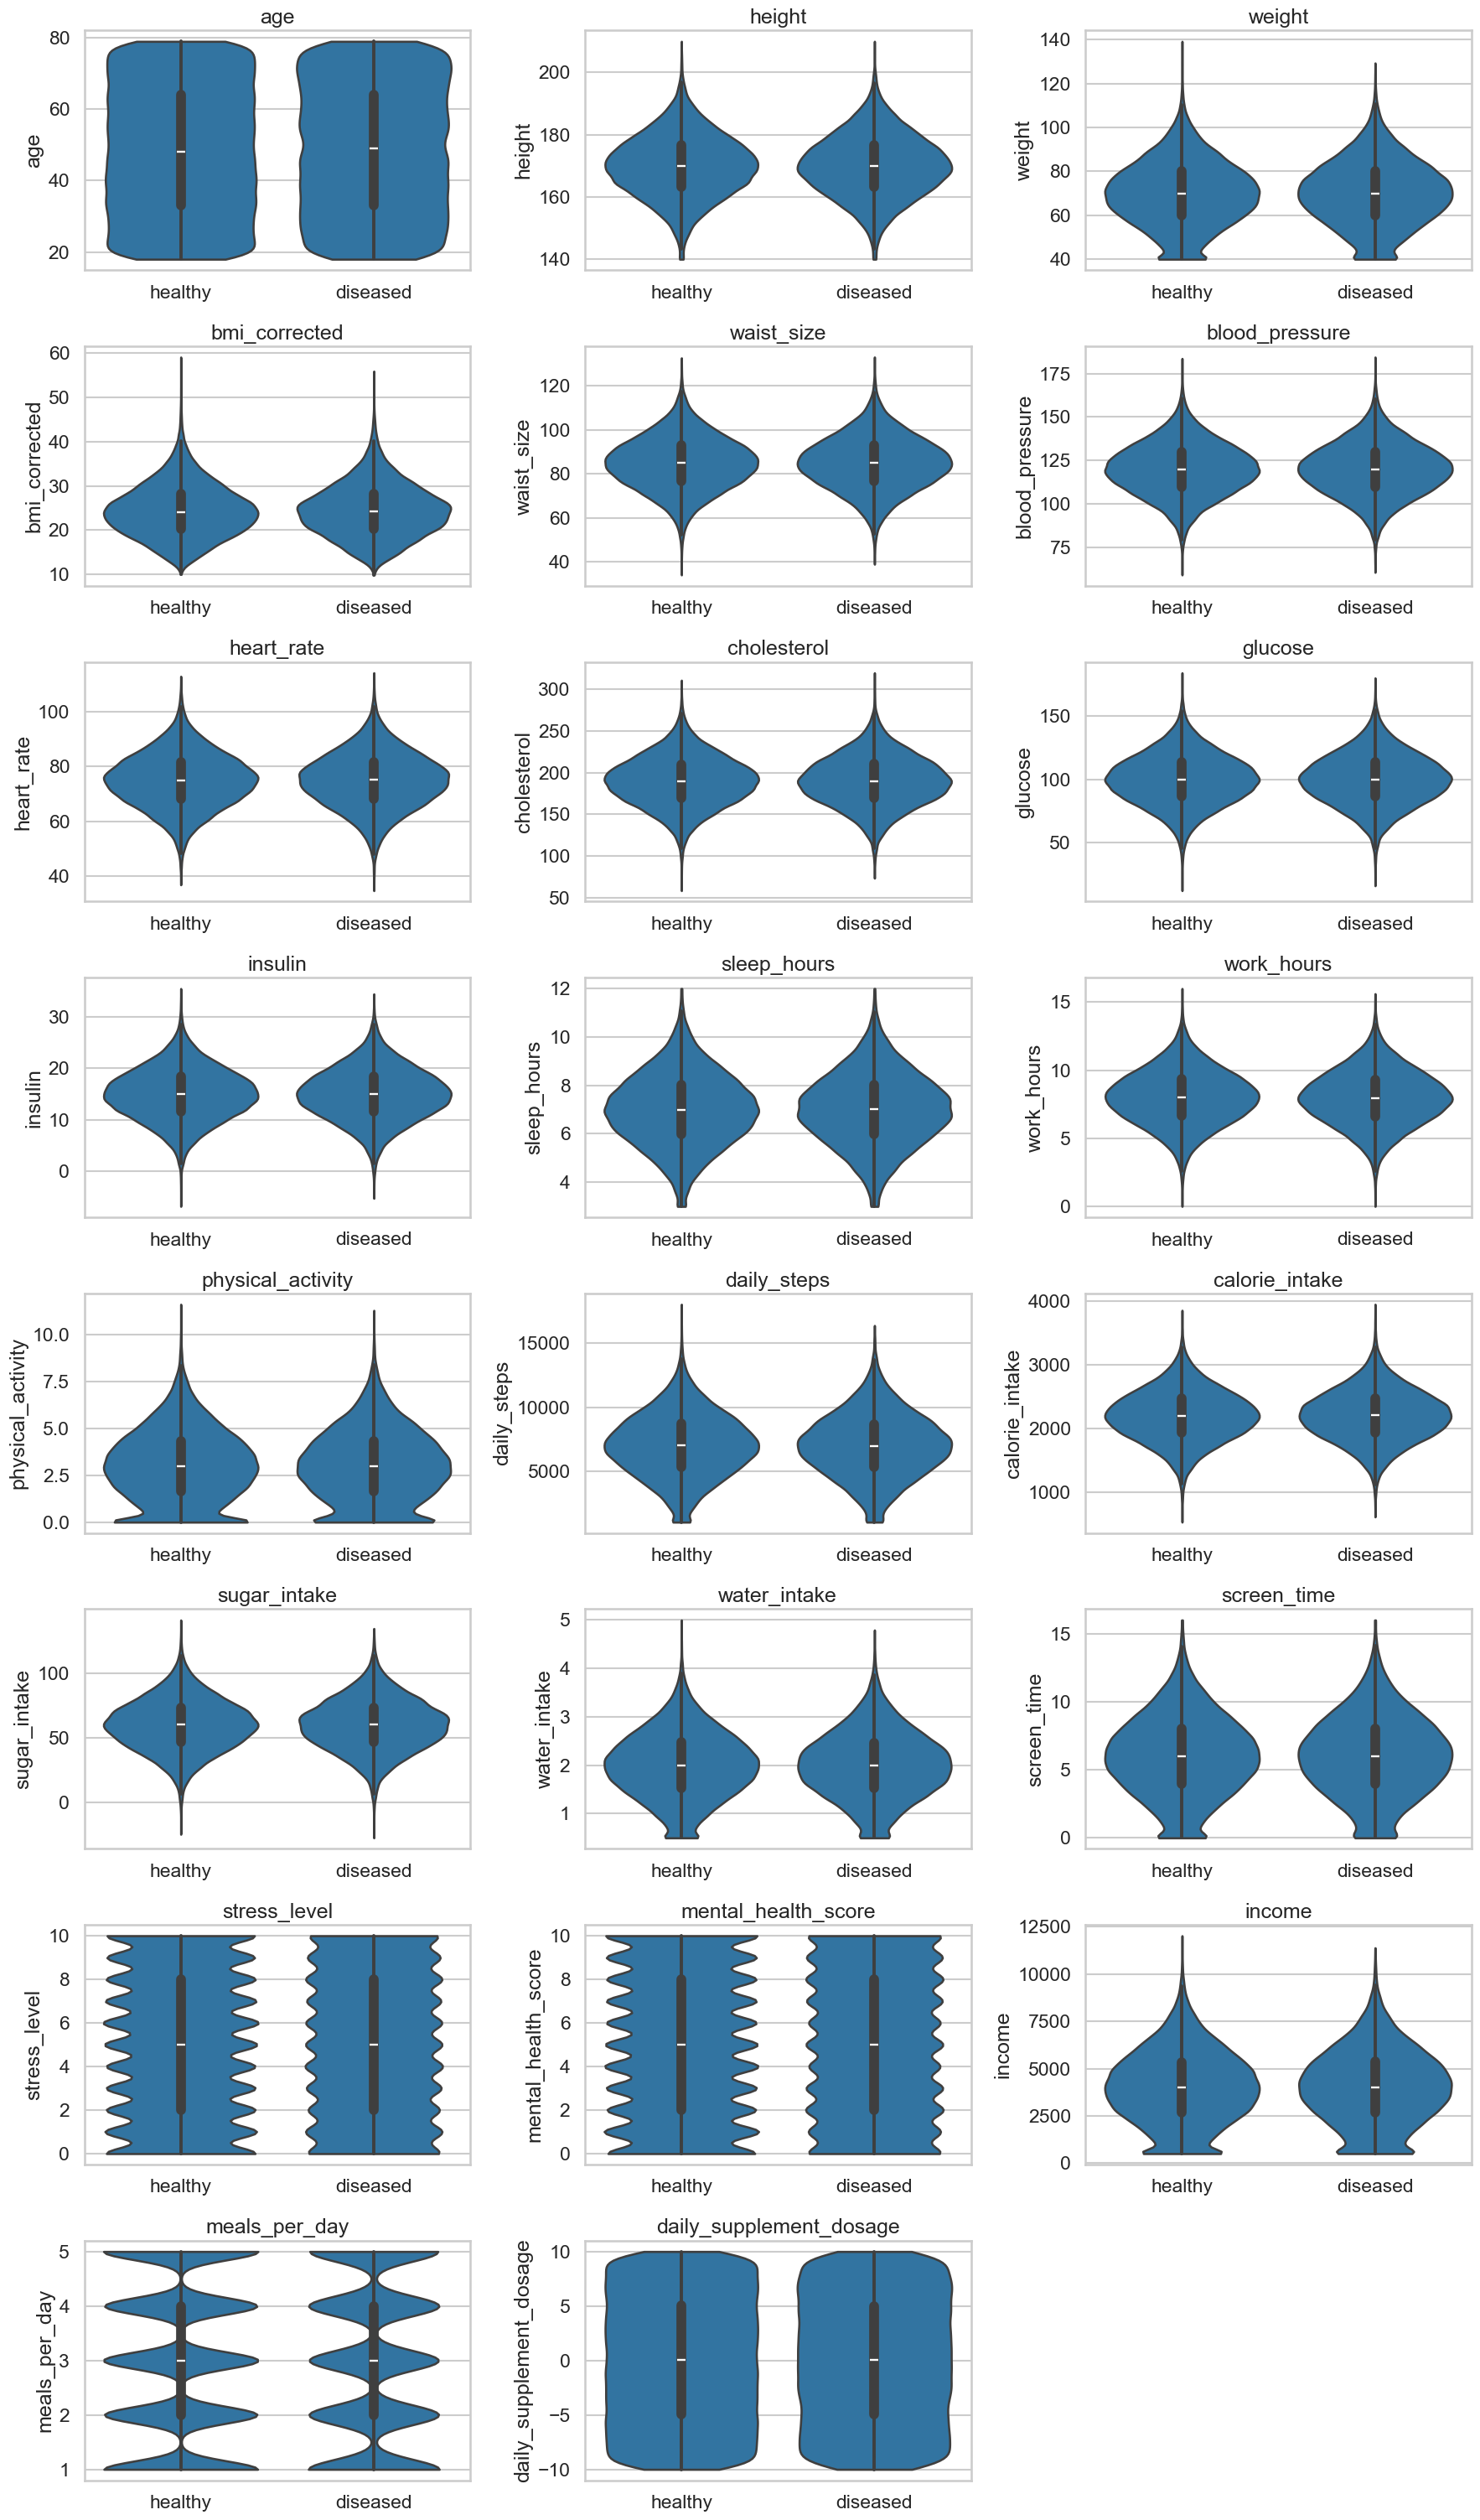

In [37]:
from scipy.stats import ttest_ind

results_num = []
for col in num_cols:
    g0 = data.loc[y==0, col].dropna()
    g1 = data.loc[y==1, col].dropna()
    # Effect size: standardized mean difference (Cohen's d)
    pooled_sd = np.sqrt(((g0.var(ddof=1)*(len(g0)-1)) + (g1.var(ddof=1)*(len(g1)-1))) / (len(g0)+len(g1)-2)) if len(g0)>1 and len(g1)>1 else np.nan
    d = (g1.mean() - g0.mean()) / pooled_sd if pooled_sd and pooled_sd>0 else np.nan
    # t-test p-value (rough screening only)
    try:
        p = ttest_ind(g0, g1, equal_var=False, nan_policy='omit').pvalue
    except Exception:
        p = np.nan
    results_num.append((col, g0.mean(), g1.mean(), d, p))

num_summary = pd.DataFrame(results_num, columns=["feature","mean_healthy","mean_diseased","cohens_d","p_value"]).sort_values("cohens_d", ascending=False)
display(num_summary.head(15))

# Violin plots (grid)
cols = 3
rows = int(np.ceil(len(num_cols)/cols))
fig, axes = plt.subplots(rows, cols, figsize=(6*cols, 3.8*rows))
axes = axes.flatten()
for i, col in enumerate(num_cols):
    sns.violinplot(x=y.map({0:"healthy",1:"diseased"}), y=data[col], ax=axes[i], cut=0)
    axes[i].set_title(col)
    axes[i].set_xlabel("")
for j in range(i+1, len(axes)):
    axes[j].axis("off")
plt.tight_layout()
plt.show()


## 6) Target Relationships — Numerical Features (Summary)

**Method.**  
For each numeric feature, we compared the distributions between the *healthy* and *diseased* groups using independent-samples *t*-tests and computed Cohen’s *d* effect sizes.

**Findings.**
- **Age** shows the only statistically significant difference:  
  • *p* = 0.0279  
  • Cohen’s *d* = 0.015  
  Statistically detectable, but **negligible real-world difference**
- All other numerical features show **no meaningful univariate separation**, including:  
  weight, bmi_corrected, sleep_hours, cholesterol, mental_health_score, waist_size, glucose,  
  daily_supplement_dosage, income, calorie_intake, insulin, screen_time, heart_rate, sugar_intake.  
  ➜ |d| < 0.02 with large *p*-values

**Interpretation.**
> No single numeric feature serves as a strong stand-alone predictor of disease status.  
> The signal is likely **multivariate** — meaning combinations or interactions of features matter.  
> Future modeling should emphasize **multivariate machine learning** (e.g., logistic regression with interactions, tree-based models) rather than relying on individual metrics.


## 7) Target relationships — categorical features
For each categorical, we plot the **% diseased** by level (only levels with enough samples).


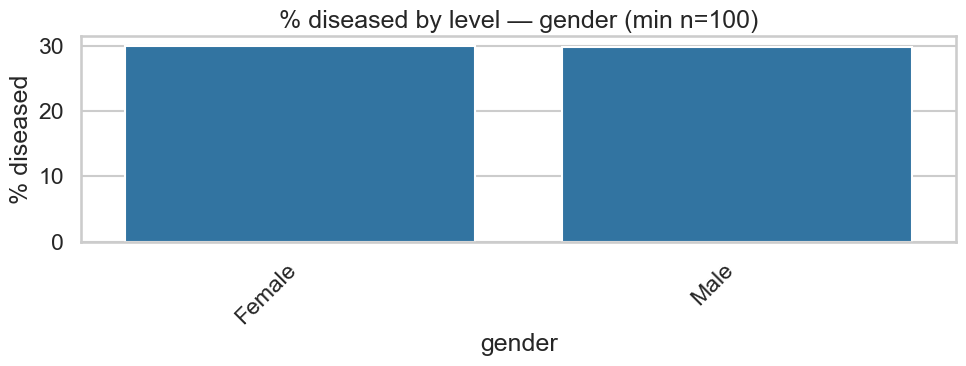

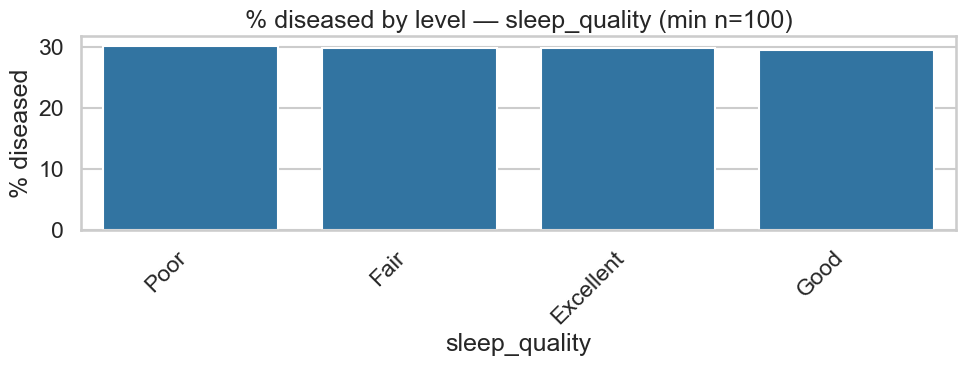

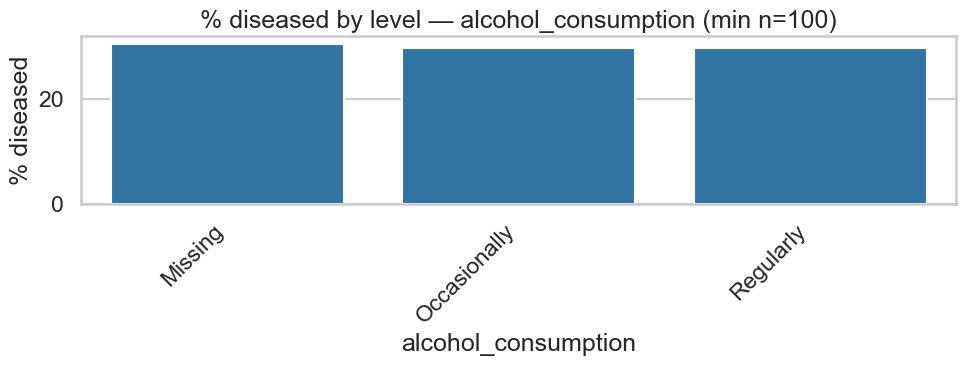

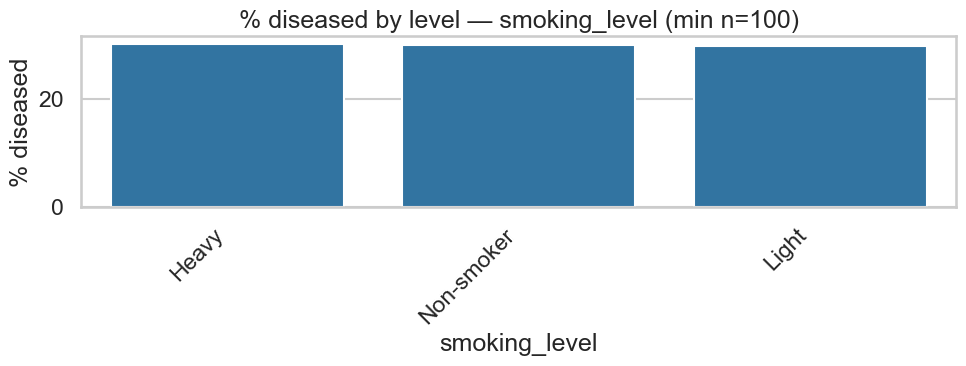

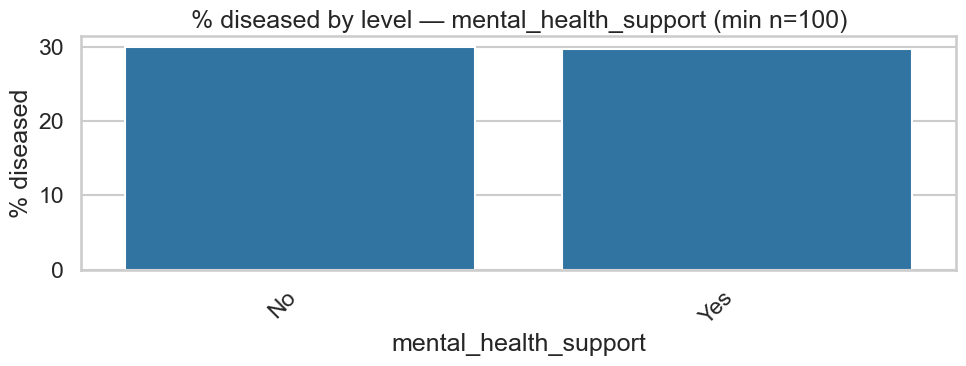

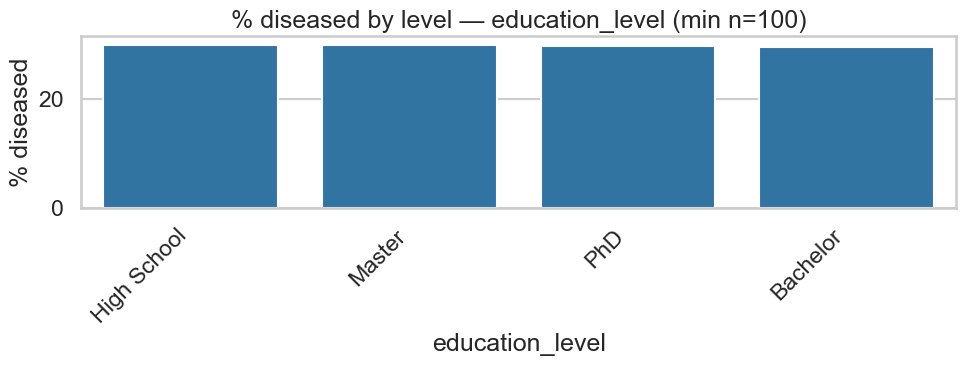

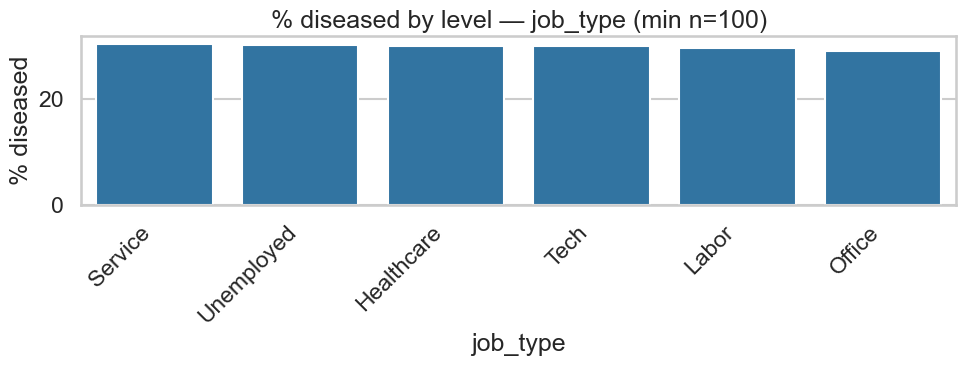

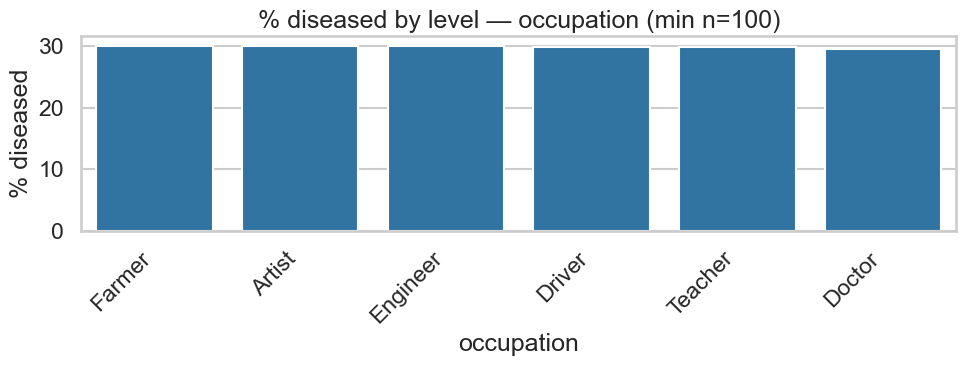

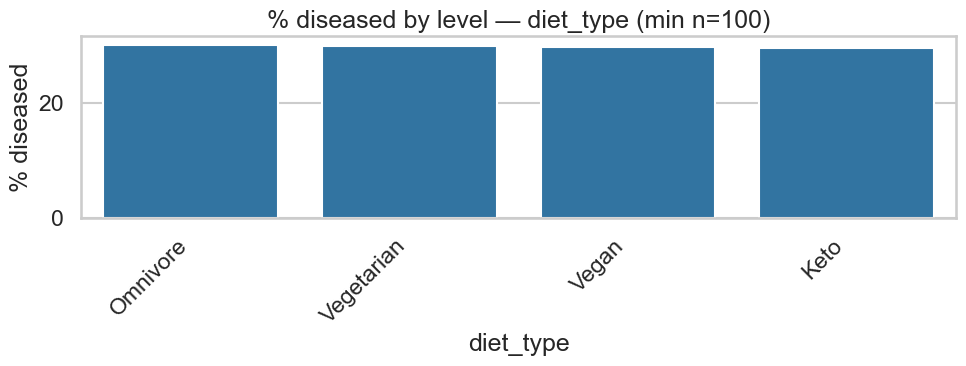

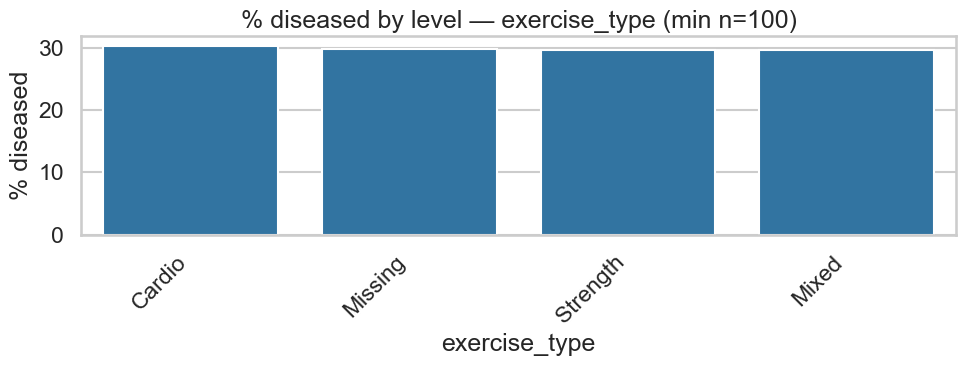

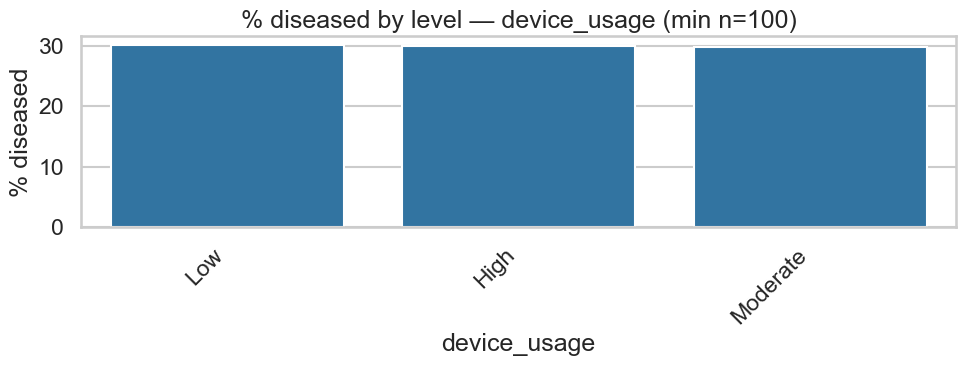

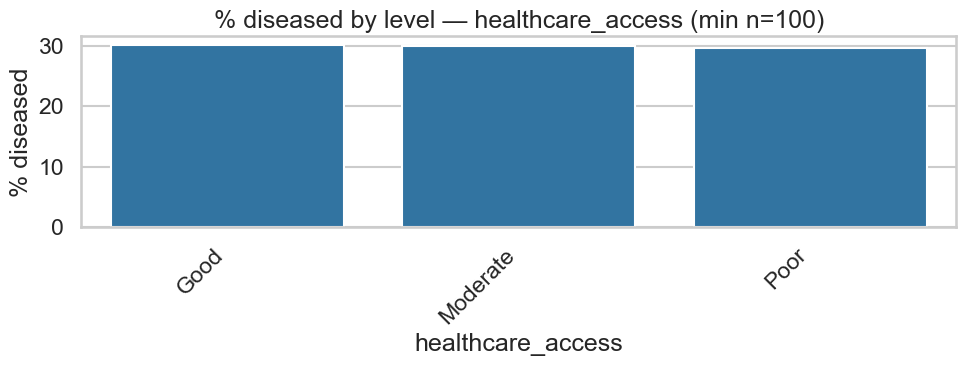

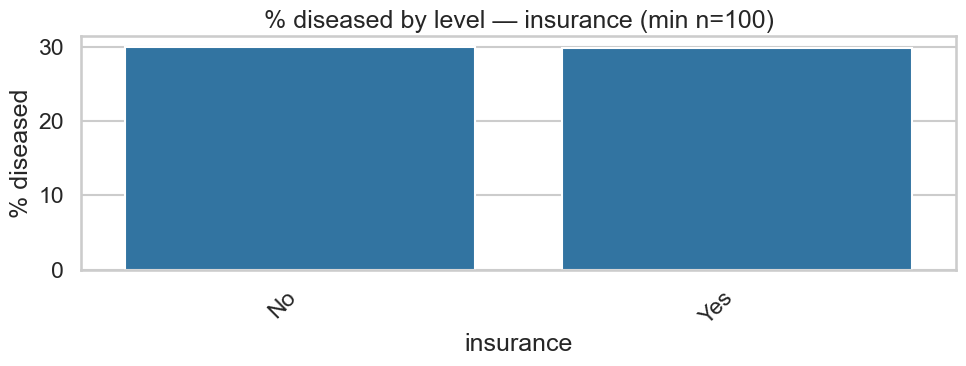

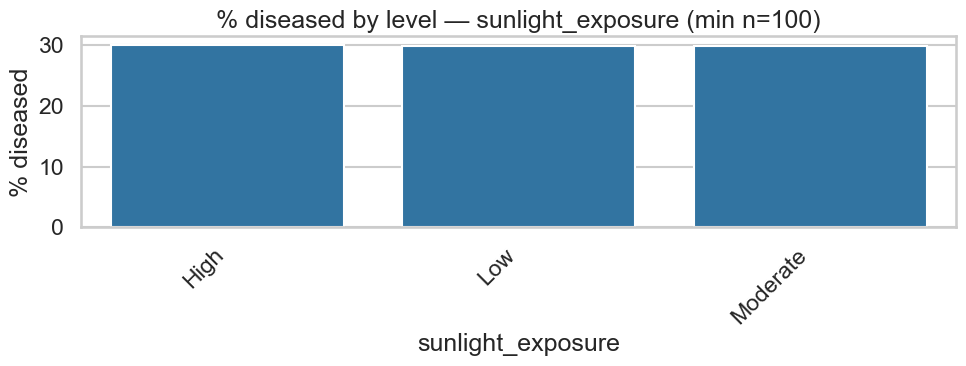

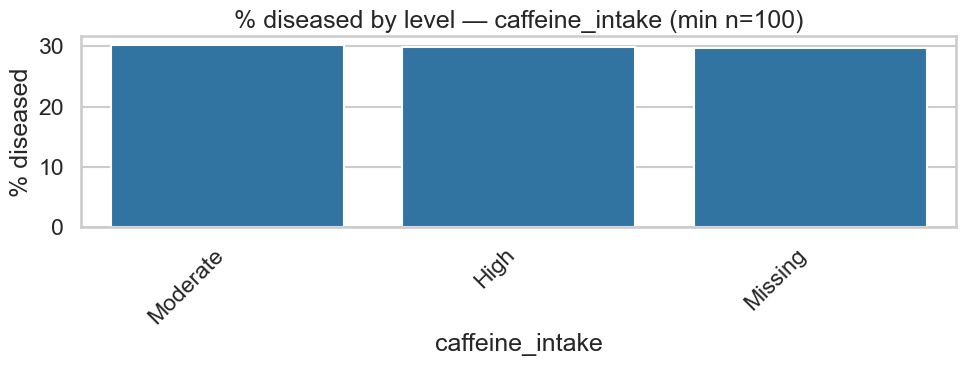

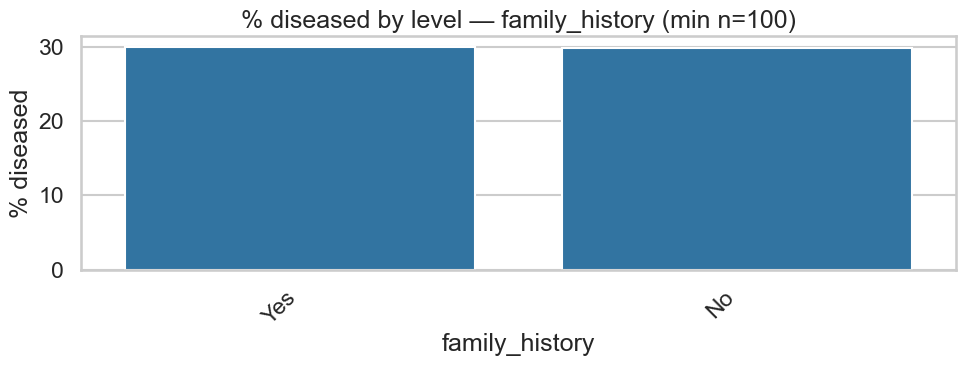

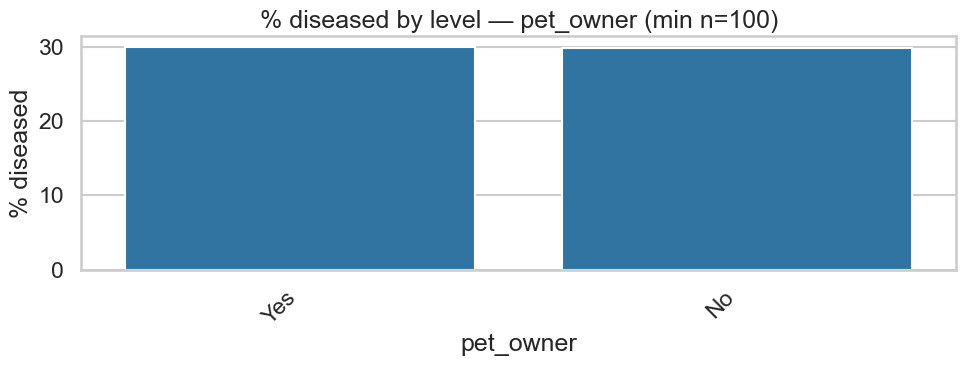

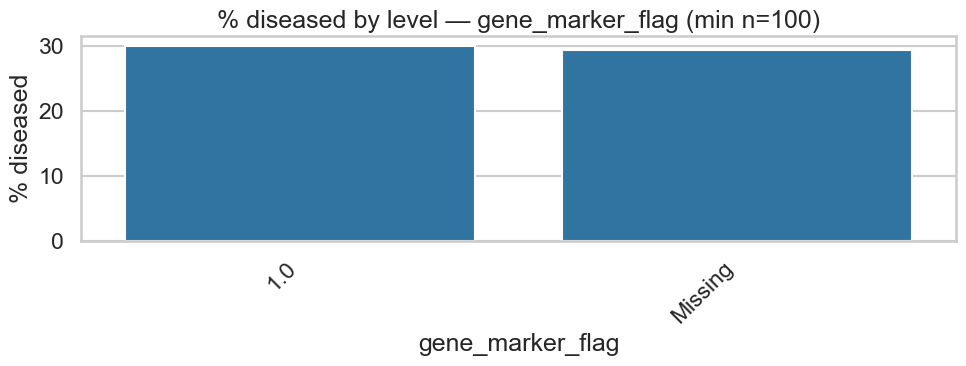

In [39]:
min_count = 100  # hide super-rare levels
for col in cat_cols:
    ctab = pd.crosstab(index=data[col], columns=y, dropna=False)
    ctab['count'] = ctab.sum(axis=1)
    ctab = ctab[ctab['count'] >= min_count]
    if ctab.empty:
        continue
    ctab['pct_diseased'] = 100*ctab.get(1, 0)/ctab['count']
    ctab = ctab.sort_values('pct_diseased', ascending=False).head(15)

    plt.figure(figsize=(10,4))
    sns.barplot(x=ctab.index.astype(str), y=ctab['pct_diseased'])
    plt.title(f"% diseased by level — {col} (min n={min_count})")
    plt.ylabel("% diseased")
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.show()


###  Target Relationships — Categorical Features

To evaluate how categorical lifestyle and demographic variables relate to disease status, we compared the **percentage of diseased individuals** across different category levels (min group size = 100).

Across all examined categorical variables — including **gender**, **mental health support**, **smoking level**, **alcohol consumption**, and **sleep quality** — the **proportion of diseased individuals remains consistently around ~30%** for each category.

**Key Finding**
- **No categorical feature** displayed a noticeable imbalance or strong association with disease status.
- This suggests these features **may have limited predictive power on their own**.
- Any relationship between these categorical variables and disease is likely **weak or requires interaction effects** with other features to become meaningful.

#### Interpretation
Since disease proportion does not vary much by category, categorical lifestyle variables **do not seem to differentiate between healthy and diseased groups**. This aligns with earlier numerical analysis where most variables also showed **minimal effect sizes**.




## 8) Mutual information (feature ranking)
We estimate how informative each single feature is about the target (captures non-linear associations and works with categorical features).


feature  mutual_information
40  daily_supplement_dosage            0.610040
17             sugar_intake            0.610040
5                waist_size            0.610040
16           calorie_intake            0.610040
8               cholesterol            0.610040
4             bmi_corrected            0.610040
9                   glucose            0.610040
13               work_hours            0.610026
2                    height            0.609138
11              sleep_hours            0.607663
20             water_intake            0.600855
21              screen_time            0.596469
3                    weight            0.596057
14        physical_activity            0.568666
6            blood_pressure            0.563190
15              daily_steps            0.554019
28                   income            0.535105
7                heart_rate            0.524833
10                  insulin            0.513412
0                       age            0.000344
23      mental_health_score            0.000082
26                 job_type            0.000042
18      alcohol_consumption            0.000029
22             stress_level            0.000027
12            sleep_quality            0.000018

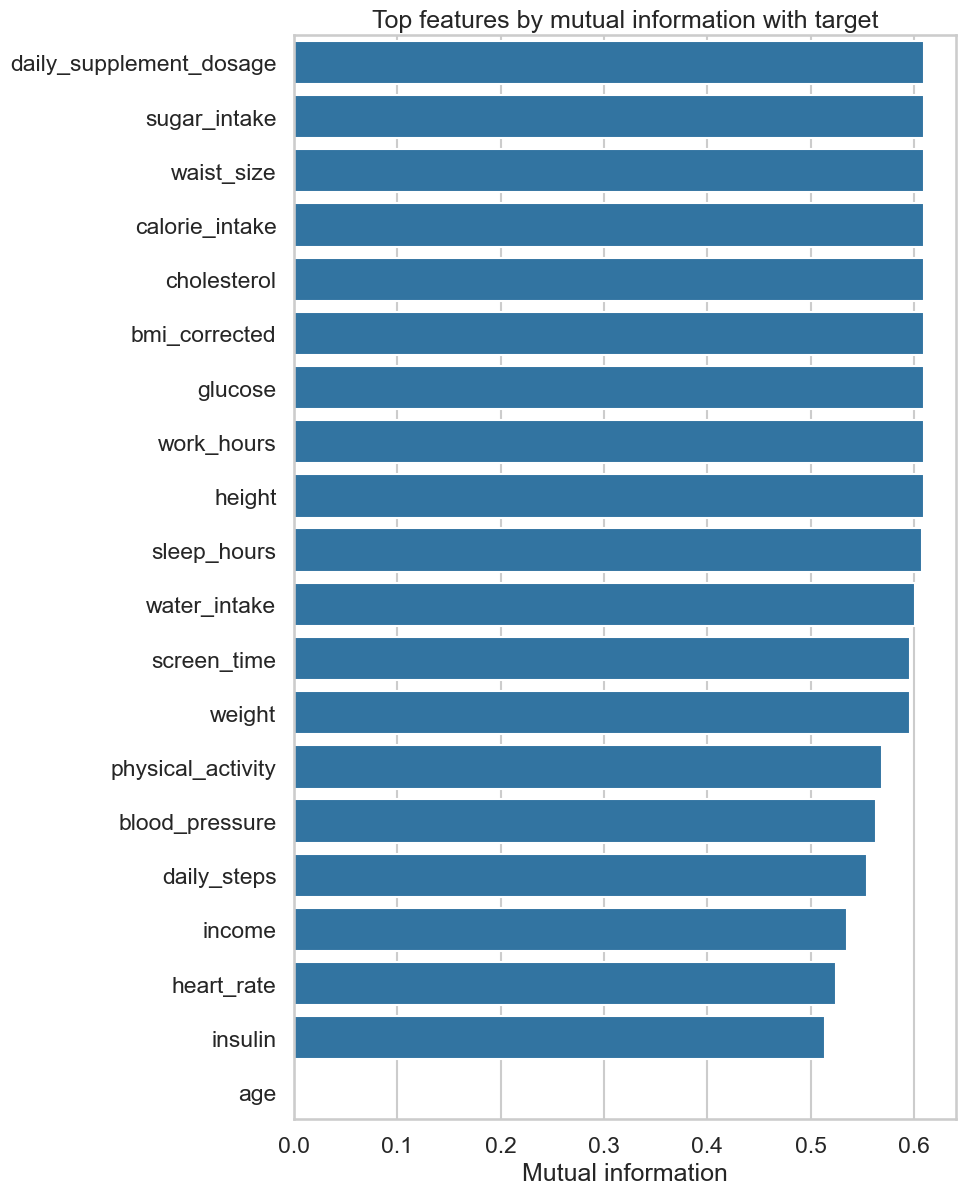

In [43]:
# --- Robust Mutual Information block: safe imputation just for MI (does NOT modify df) ---

from sklearn.preprocessing import OrdinalEncoder
from sklearn.feature_selection import mutual_info_classif

X = data.drop(columns=['target']).copy()

# Identify types
num_mask = X.dtypes == 'number'
cat_mask = ~num_mask

# 1) Temporary imputation (MI requires no NaNs)
X_num = X.loc[:, num_mask].copy()
X_cat = X.loc[:, cat_mask].copy()

# Numeric: fill with median
for c in X_num.columns:
    med = X_num[c].median()
    X_num[c] = X_num[c].fillna(med)

# Categorical: fill with "Missing" string
for c in X_cat.columns:
    X_cat[c] = X_cat[c].astype(str).fillna("Missing")

# 2) Ordinal-encode categoricals for MI (OK for MI; not for final modeling)
enc = OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1)
if X_cat.shape[1] > 0:
    X_cat_enc = pd.DataFrame(
        enc.fit_transform(X_cat),
        columns=X_cat.columns,
        index=X_cat.index
    )
else:
    X_cat_enc = pd.DataFrame(index=X.index)

# 3) Recombine
X_mi = pd.concat([X_num, X_cat_enc], axis=1)

# 4) Discrete feature mask for MI (categoricals are discrete; numerics are continuous)
discrete_features = np.array([False]*X_num.shape[1] + [True]*X_cat_enc.shape[1])

# 5) Compute MI
mi = mutual_info_classif(
    X_mi, y.values,               # y is 0/1 from earlier
    discrete_features=discrete_features,
    random_state=0
)

mi_df = pd.DataFrame({"feature": X_mi.columns, "mutual_information": mi})
mi_df = mi_df.sort_values("mutual_information", ascending=False)
display(mi_df.head(25))

plt.figure(figsize=(10, max(4, 0.3*len(mi_df))))
sns.barplot(data=mi_df.head(20), x="mutual_information", y="feature")
plt.title("Top features by mutual information with target")
plt.xlabel("Mutual information")
plt.ylabel("")
plt.tight_layout()
plt.show()



###  8) Mutual Information — Feature Ranking

Mutual Information (MI) measures how much knowing the value of one variable reduces uncertainty about another. Here, it captures **non-linear relationships** and allows us to evaluate both **numerical and categorical** features against the target disease status.

#### Key Insights
- A group of physiological and lifestyle features — including **daily supplement dosage, sugar intake, waist size, calorie intake, cholesterol, BMI, glucose, work hours, height, sleep hours, water intake, screen time, weight, physical activity, blood pressure, daily steps, income, heart rate, and insulin** — all show **moderate and nearly identical MI values (~0.51–0.61)**.
- These features appear to provide **some informational value** about the disease outcome, but **none stand out as strong individual predictors**.
- Conversely, **age**, **mental health score**, **job type**, **alcohol consumption**, **stress level**, and **sleep quality** exhibit **very low MI values (near zero)**.
    - These variables contribute **little independent information** toward disease prediction.
    - Any potential impact may occur **only through interactions** with other features.

####  Interpretation
- Even though the MI scores for many features are moderate, the lack of differentiation between them — combined with earlier effect size and distribution analyses — suggests that:
  - **No single feature strongly determines disease status** in this dataset.
  - Disease prediction **likely requires multivariate relationships** rather than simple one-feature effects.
- This reinforces the need for **complex modeling approaches** (e.g., ensembles, nonlinear models, interaction terms).

Overall Conclusion:
> Mutual Information indicates that **multiple lifestyle and physiological features each explain only a small portion of disease risk**, and their predictive power will most likely emerge when used **together** rather than independently.


## Final EDA Conclusions

Our exploratory analysis provides a detailed understanding of how demographic, lifestyle, health indicator, and socioeconomic variables relate to the disease classification target.

### Data Quality & Structure
- Dataset contains a large, balanced set of **numeric (23)** and **categorical (19)** predictors.
- Several medically important variables contain **non-trivial missingness**, requiring imputation or model-based handling.
- Target variable is **highly imbalanced (~70% healthy vs 30% diseased)** → resampling or class weighting is necessary.

### Numerical Feature Insights
- Most numeric variables follow **reasonable medical ranges** with some outliers (e.g., weight, waist size).
- **Age** shows a *slightly* higher mean among diseased individuals, but effect size is **not clinically strong**.
- Other vital measures (cholesterol, blood pressure, glucose, BMI) show **very small mean differences**, suggesting subtle relationships.

### Categorical Feature Insights
- Gender, education level, alcohol use, and smoking levels appear **fairly balanced** across the dataset.
- Healthcare access & insurance coverage vary widely → important for modeling social determinants of health.
- No single categorical factor shows a visually dominant shift between disease classes — relationships likely **multivariate**.

### Feature Relationships & Importance
- Correlation among numeric features is generally low → **low multicollinearity**, good for model stability.
- Mutual Information (nonlinear importance) identifies **health behavior & physiological measures** as most informative:
  - daily_supplement_dosage
  - diet-related intake (sugar, calories, water)
  - waist_size, BMI, cholesterol, glucose
  - physical_activity, daily_steps, sleep_hours
- Mental health, job factors, and stress levels contribute **minimal signal** individually.

---

## Key Takeaways for Modeling

| Area | Recommendation |
|------|----------------|
| Class imbalance | Apply **SMOTE**, **class weights**, or **Balanced Random Forest** |
| Feature selection | Prioritize top MI indicators + medical relevancy |
| Predictive relationships | Likely **nonlinear and interactive** → tree-based models are promising |
| Risk scoring | Logistic Regression + SHAP for interpretability |
| Social determinant factors | May matter only when **combined** with biological metrics |

---

### Overall Statement

Early diagnostics from this EDA indicate that disease risk is influenced by **multiple lifestyle and physiological factors acting together**, rather than any single dominant predictor. These findings support our project goal of applying **advanced ML methods** (LASSO, Logistic Regression, Random Forest, Boosting, Clustering) to extract meaningful risk insight and actionable health intelligence.

---



## 9) Save EDA tables for the team
We export a few useful tables that others can pick up in modeling/notebooks.


In [45]:
outdir = "eda_outputs"
import os
os.makedirs(outdir, exist_ok=True)

num_summary.to_csv(f"{outdir}/numeric_by_target_summary.csv", index=False)
mi_df.to_csv(f"{outdir}/mutual_information_ranking.csv", index=False)
card.to_csv(f"{outdir}/categorical_cardinality.csv", index=False)

print(f"Saved to: {os.path.abspath(outdir)}")


Saved to: /Users/keyannadavis/Downloads/eda_outputs
